<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>neural network architecture</a></span><ul class="toc-item"><li><span><a href="#training" data-toc-modified-id="training-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>training</a></span></li><li><span><a href="#results" data-toc-modified-id="results-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>results</a></span></li></ul></li><li><span><a href="#experimentos" data-toc-modified-id="experimentos-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>experimentos</a></span><ul class="toc-item"><li><span><a href="#relu" data-toc-modified-id="relu-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>relu</a></span><ul class="toc-item"><li><span><a href="#batch-normalization" data-toc-modified-id="batch-normalization-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>batch normalization</a></span></li></ul></li><li><span><a href="#leaky-relu" data-toc-modified-id="leaky-relu-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>leaky relu</a></span></li><li><span><a href="#tanh" data-toc-modified-id="tanh-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>tanh</a></span></li><li><span><a href="#gelu" data-toc-modified-id="gelu-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>gelu</a></span></li><li><span><a href="#elu" data-toc-modified-id="elu-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>elu</a></span></li><li><span><a href="#swish" data-toc-modified-id="swish-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>swish</a></span></li></ul></li></ul></div>

# setup

In [40]:
import os
import warnings
import pprint
import gc
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size'       : 9,
    'figure.figsize'  : (3.5, 2.8),
    'figure.dpi'      : 300,
    'savefig.dpi'     : 300,
    'text.usetex'     : True,
    'font.family'     : 'serif',
    'font.serif'      : ['Times New Roman'],
    'axes.labelsize'  : 9,
    'axes.titlesize'  : 9,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'legend.fontsize' : 8,
    'lines.linewidth' : 1,
    'axes.linewidth'  : 1,
    'grid.linestyle'  : '--',
    'grid.linewidth'  : 0.5,
    'grid.alpha'      : 0.8,
})

sns.set_context(
    "paper", 
    rc={
        "font.size"      : 9,
        "axes.titlesize" : 9,
        "axes.labelsize" : 9, 
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

In [4]:
experiment_name = "newton_law_cooling"
folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

golden_ratio = (np.sqrt(5) - 1) / 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# neural network architecture

In [5]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

# data

$$ \frac{dT}{dt} = k (T-S) $$ 

where $k<0$ is a constant. 

$$ T=(T_0-S) e^{kt} + S \qquad \qquad  $$

where $T_0$ is the initial temperature.

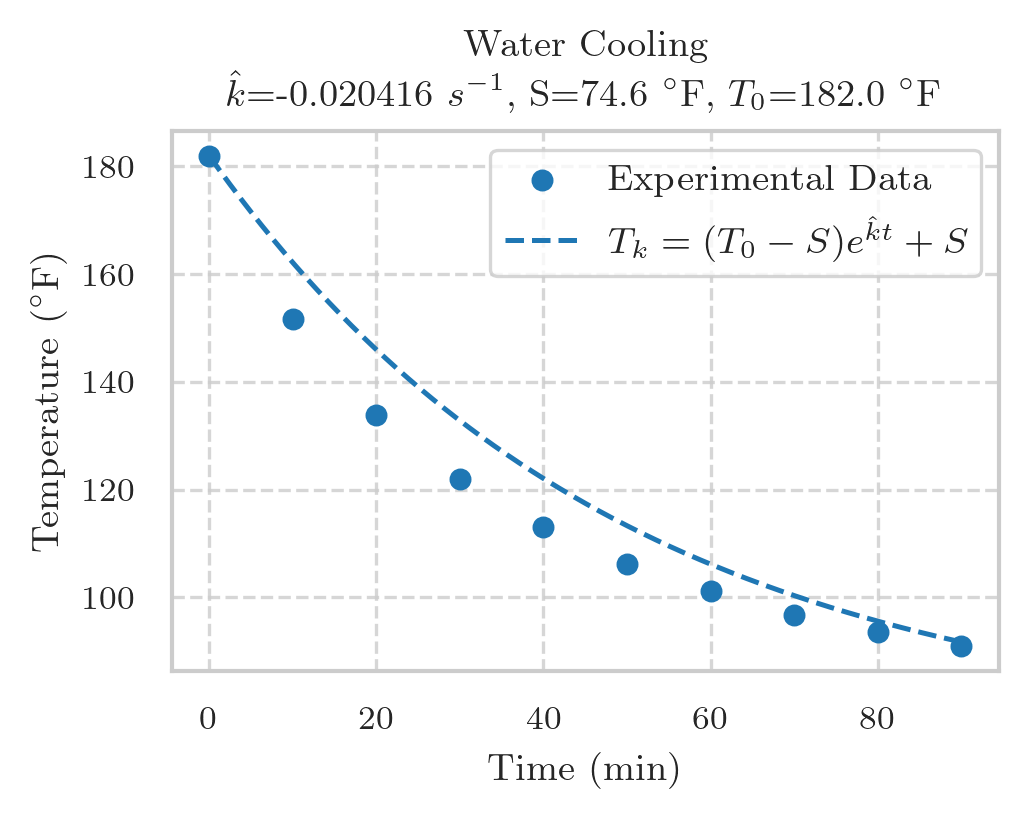

In [6]:
# raw data
data = [
    [0,	10,	20,	30,	40,	50,	60,	70,	80,	90],
    [182.0,	151.7,	133.9,	122.0,	113.1,	106.2,	101.1,	96.7,	93.5,	90.9],
]
X = pd.DataFrame(data).T.rename(columns={0: 'time', 1: 'temperature'}).astype({'time': int})
X.to_parquet(f"{folder_path}/experimental_data.parquet")

# physical parameters
S = 74.6
k = -0.020416
T_0 = X['temperature'][0]

# plot
fig, (ax1) = plt.subplots(ncols=1, nrows=1)

X.plot.scatter(x='time', y='temperature', ax=ax1, label="Experimental Data")

t = np.linspace(0, 90, 1000)
T = (T_0 - S) * np.exp(k * t) + S

ax1.plot(t, T, label="$T_k=(T_0-S) e^{\hat{k}t} + S$", linestyle='--') 
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Temperature ($^\circ$F)")
ax1.set_title("Water Cooling \n $\hat{k}$=-0.020416 $s^{-1}$, S=74.6 $^\circ$F, $T_0$=182.0 $^\circ$F")

plt.legend()
plt.tight_layout()
plt.savefig(f"{folder_path}/plot_line_temperature_vs_time.png")

# experiments

In [41]:
folder_path = f"../data/08_reporting/{experiment_name}/random_grid_search"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

## random grid search

here only uniform multilayer perceptrons are considered.

In [69]:
def network_training(data, hyperparameters):
    """
    network_training
    """    
    torch.manual_seed(0)
    np.random.seed(0)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)

    _S = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
    _T0 = torch.tensor(T_0, dtype=torch.float, requires_grad=False, device=device)
    _k = torch.tensor(1.0, dtype=torch.float, requires_grad=True, device=device)

    x_train = torch.tensor(data["time"].values).float().unsqueeze(1).to(device)
    y_train = torch.tensor(data["temperature"].values).float().unsqueeze(1).to(device)

    hparam_dict = {
        'lambda_physics_loss' : hyperparameters['lambda_physics_loss'],
        'learning_rate': hyperparameters['learning_rate'],
        'n_layers': hyperparameters['n_layers'],
        'n_neurons': hyperparameters['n_neurons'],
        'num_epochs': hyperparameters['num_epochs'],
        'num_collocation_points': hyperparameters['num_collocation_points'],
        'activation': hyperparameters['activation'],
    }
    _architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]
    _collocation = torch.linspace(0, 90, hparam_dict["num_collocation_points"]).view(-1,1).requires_grad_(True).to(device)

    pprint.pprint(hparam_dict)

    model = MultiLayerPerceptronRegressor(_architecture, hparam_dict["activation"]).to(device)
    optimizer = optim.Adam(
        [
            {"params": model.parameters()}, 
            {"params": [_k]}
        ], 
        lr=hparam_dict["learning_rate"]
    )
    criterion = nn.MSELoss()

    plot_loss_train = dict(
        epoch=list(),
        dataloss=list(), 
        physicsloss=list(), 
        k=list()
    )
    for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
        optimizer.zero_grad()

        # forward
        y_train_hat = model(x_train)
        data_loss = criterion(y_train_hat, y_train)

        y_location_hat = model(_collocation)
        dydt = torch.autograd.grad(y_location_hat, _collocation, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]

        _diff_equation = dydt - _k * (y_location_hat - _S)

        physics_loss = torch.mean(_diff_equation**2)
        _T0_loss = criterion(y_location_hat[0], _T0)

        loss = data_loss + (1e-2)*(physics_loss + _T0_loss)
        
        # backward
        loss.backward()
        optimizer.step()

        if (epoch+1) % 5 == 0:
            plot_loss_train["epoch"].append(epoch+1)
            plot_loss_train["dataloss"].append(data_loss.item())
            plot_loss_train["physicsloss"].append(physics_loss.item())
            plot_loss_train["k"].append(_k.item())
    
    gc.collect()

    _k_hat = _k.item()
    _mse = mean_squared_error(
        data['temperature'], 
        (T_0 - S) * np.exp(_k_hat * data['time']) + S
    )
    print(f"mse: {_mse:.4f}")
    print(f"k_hat: {_k_hat:.4f}")
    print()

    return pd.DataFrame(plot_loss_train), dict(k_hat=_k_hat, mse=_mse)

In [64]:
param_grid = {
    'lambda_physics_loss' : [0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate': [0.00001, 0.0001, 0.001, 0.1],
    'n_layers': [2, 3, 4, 5],
    'n_neurons': [8, 16, 32, 64, 128],
    'num_epochs': [100, 1000, 10000, 100000],
    'num_collocation_points': [10, 20, 30, 40, 50],
    'activation': [nn.Tanh, nn.ELU, nn.LeakyReLU, nn.ReLU]
}

In [70]:
np.random.seed(33)

for _index, _hparam in enumerate(np.random.choice(ParameterGrid(param_grid), 2, replace=False)):
    _history, _metrics = network_training(X.copy(), _hparam)

    folder_path = f"../data/08_reporting/{experiment_name}/random_grid_search/trial_{str(_index).zfill(3)}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    _hparam["activation"] = _hparam["activation"].__name__
    json.dump(_hparam, open(f"{folder_path}/hyperparameters.json", 'w'))
    json.dump(_metrics, open(f"{folder_path}/metrics.json", 'w'))
    _history.to_parquet(f"{folder_path}/history.parquet")

0it [00:00, ?it/s]

{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.0001,
 'n_layers': 2,
 'n_neurons': 128,
 'num_collocation_points': 20,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:02<00:00, 379.77it/s]
1it [00:02,  2.75s/it]

mse: 304270601229095077637526151700421755584091092837219229334604133755734982656.0000
k_hat: 0.9136

{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.001,
 'n_layers': 3,
 'n_neurons': 16,
 'num_collocation_points': 20,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:29<00:00, 335.28it/s]
2it [00:32, 16.34s/it]

mse: 30.3544
k_hat: -0.0285



In [68]:
display( pd.read_parquet(f"../data/08_reporting/{experiment_name}/random_grid_search/trial_000/history.parquet") )

print(json.load(open(f"../data/08_reporting/{experiment_name}/random_grid_search/trial_000/hyperparameters.json", 'r')))

print(json.load(open(f"../data/08_reporting/{experiment_name}/random_grid_search/trial_000/metrics.json", 'r')))

,epoch,dataloss,physicsloss,k
0,5,14850.447266,5484.403809,0.999500
1,10,14795.534180,5441.534668,0.999000
2,15,14741.445312,5399.382812,0.998501
3,20,14688.291016,5358.031250,0.998003
4,25,14636.125000,5317.511719,0.997507
...,...,...,...,...
195,980,10843.756836,2612.760986,0.915159
196,985,10830.043945,2604.203613,0.914776
197,990,10816.358398,2595.674805,0.914394
198,995,10802.695312,2587.175049,0.914012


{'activation': 'Tanh', 'lambda_physics_loss': 0.001, 'learning_rate': 0.0001, 'n_layers': 2, 'n_neurons': 128, 'num_collocation_points': 20, 'num_epochs': 1000}
{'k_hat': 0.9136306047439575, 'mse': 3.042706012290951e+74}


In [120]:
hparam_dict = {
    'learning_rate': 1e-3,
    'n_layers': 4,
    'n_neurons': 32,
    'num_epochs': 50000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

In [121]:
_locations = torch.linspace(0, 90, 45).view(-1,1).requires_grad_(True).to(device)
_S = torch.tensor(S, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(1.0, dtype=torch.float, requires_grad=True, device=device)
_T0 = torch.tensor(X["temperature"][0], dtype=torch.float, requires_grad=False).to(device)

model = MultiLayerPerceptronRegressor(architecture, nn.ELU)
model.to(device)
optimizer = optim.Adam([
    {"params": model.parameters()}, 
    {"params": [_k]}
], lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], k=[])

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]

    _diff_equation = dydt - _k * (y_location_hat - _S)

    physics_loss = torch.mean(_diff_equation**2)
    _T0_loss = criterion(y_location_hat[0], _T0)

    loss = data_loss + (1e-2)*(physics_loss + _T0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, T0 Loss: {_T0_loss.item():.6f}, Total Loss: {loss.item():.6f}")
        print(f"k: {_k.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())
        plot_loss_train["k"].append(_k.item())

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|          | 0/50000 [00:00<?, ?it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1045/50000 [00:04<03:36, 225.85it/s]

Data Loss: 0.015310, Physics Loss: 242.697647, T0 Loss: 0.002704, Total Loss: 2.442314
k: 0.290189


  4%|▍         | 2025/50000 [00:08<03:23, 235.22it/s]

Data Loss: 0.002063, Physics Loss: 3.649755, T0 Loss: 0.000002, Total Loss: 0.038560
k: 0.010085


  6%|▌         | 3025/50000 [00:12<03:26, 227.74it/s]

Data Loss: 0.000457, Physics Loss: 0.537613, T0 Loss: 0.000006, Total Loss: 0.005833
k: -0.021961


  8%|▊         | 4043/50000 [00:17<03:09, 242.81it/s]

Data Loss: 0.044423, Physics Loss: 0.244210, T0 Loss: 0.000095, Total Loss: 0.046866
k: -0.023753


 10%|█         | 5039/50000 [00:20<03:16, 228.59it/s]

Data Loss: 0.000275, Physics Loss: 0.122209, T0 Loss: 0.000001, Total Loss: 0.001497
k: -0.024596


 12%|█▏        | 6018/50000 [00:24<02:53, 253.40it/s]

Data Loss: 0.000333, Physics Loss: 0.070976, T0 Loss: 0.000000, Total Loss: 0.001042
k: -0.024998


 14%|█▍        | 7038/50000 [00:28<02:28, 289.70it/s]

Data Loss: 0.000255, Physics Loss: 0.057323, T0 Loss: 0.000001, Total Loss: 0.000828
k: -0.025175


 16%|█▌        | 8061/50000 [00:32<02:10, 322.04it/s]

Data Loss: 0.000760, Physics Loss: 0.051611, T0 Loss: 0.000026, Total Loss: 0.001276
k: -0.025236


 18%|█▊        | 9067/50000 [00:35<01:59, 341.27it/s]

Data Loss: 0.008776, Physics Loss: 0.048903, T0 Loss: 0.000273, Total Loss: 0.009268
k: -0.025275


 20%|██        | 10066/50000 [00:38<01:49, 363.90it/s]

Data Loss: 0.000044, Physics Loss: 0.048154, T0 Loss: 0.000000, Total Loss: 0.000526
k: -0.025305


 22%|██▏       | 11027/50000 [00:41<02:29, 261.08it/s]

Data Loss: 0.000224, Physics Loss: 0.047542, T0 Loss: 0.000013, Total Loss: 0.000700
k: -0.025344


 24%|██▍       | 12066/50000 [00:44<01:34, 403.07it/s]

Data Loss: 0.000092, Physics Loss: 0.046305, T0 Loss: 0.000000, Total Loss: 0.000555
k: -0.025294


 26%|██▌       | 13025/50000 [00:47<01:43, 357.49it/s]

Data Loss: 0.000108, Physics Loss: 0.045545, T0 Loss: 0.000003, Total Loss: 0.000563
k: -0.025271


 28%|██▊       | 14050/50000 [00:50<02:01, 296.54it/s]

Data Loss: 0.000050, Physics Loss: 0.044940, T0 Loss: 0.000000, Total Loss: 0.000499
k: -0.025248


 30%|███       | 15045/50000 [00:54<02:29, 234.25it/s]

Data Loss: 0.000118, Physics Loss: 0.044847, T0 Loss: 0.000000, Total Loss: 0.000566
k: -0.025255


 32%|███▏      | 16025/50000 [00:58<02:28, 228.86it/s]

Data Loss: 0.001083, Physics Loss: 0.044479, T0 Loss: 0.000101, Total Loss: 0.001528
k: -0.025203


 34%|███▍      | 17041/50000 [01:02<01:54, 287.99it/s]

Data Loss: 0.000088, Physics Loss: 0.044913, T0 Loss: 0.000000, Total Loss: 0.000537
k: -0.025191


 36%|███▌      | 18052/50000 [01:05<01:33, 340.58it/s]

Data Loss: 0.020310, Physics Loss: 0.045167, T0 Loss: 0.003424, Total Loss: 0.020796
k: -0.025135


 38%|███▊      | 19042/50000 [01:08<01:43, 297.83it/s]

Data Loss: 0.000219, Physics Loss: 0.044575, T0 Loss: 0.000000, Total Loss: 0.000665
k: -0.025151


 40%|████      | 20077/50000 [01:12<01:20, 369.87it/s]

Data Loss: 0.011005, Physics Loss: 0.044269, T0 Loss: 0.002063, Total Loss: 0.011469
k: -0.025125


 42%|████▏     | 21043/50000 [01:15<01:16, 380.76it/s]

Data Loss: 0.000443, Physics Loss: 0.044144, T0 Loss: 0.000095, Total Loss: 0.000886
k: -0.025136


 44%|████▍     | 22025/50000 [01:17<01:52, 247.94it/s]

Data Loss: 0.000060, Physics Loss: 0.044124, T0 Loss: 0.000000, Total Loss: 0.000501
k: -0.025122


 46%|████▌     | 23031/50000 [01:21<01:58, 227.39it/s]

Data Loss: 0.000059, Physics Loss: 0.043696, T0 Loss: 0.000004, Total Loss: 0.000496
k: -0.025103


 48%|████▊     | 24043/50000 [01:25<01:28, 294.19it/s]

Data Loss: 0.000059, Physics Loss: 0.043463, T0 Loss: 0.000001, Total Loss: 0.000493
k: -0.025086


 50%|█████     | 25029/50000 [01:29<01:44, 239.94it/s]

Data Loss: 0.000131, Physics Loss: 0.043168, T0 Loss: 0.000022, Total Loss: 0.000563
k: -0.025065


 52%|█████▏    | 26032/50000 [01:33<01:43, 230.53it/s]

Data Loss: 0.022383, Physics Loss: 0.043170, T0 Loss: 0.005595, Total Loss: 0.022871
k: -0.024999


 54%|█████▍    | 27025/50000 [01:38<01:38, 233.98it/s]

Data Loss: 0.000030, Physics Loss: 0.042674, T0 Loss: 0.000004, Total Loss: 0.000456
k: -0.025032


 56%|█████▌    | 28029/50000 [01:42<01:36, 227.79it/s]

Data Loss: 0.000024, Physics Loss: 0.042170, T0 Loss: 0.000000, Total Loss: 0.000446
k: -0.025012


 58%|█████▊    | 29048/50000 [01:45<01:16, 272.51it/s]

Data Loss: 0.000029, Physics Loss: 0.041658, T0 Loss: 0.000000, Total Loss: 0.000446
k: -0.024981


 60%|██████    | 30034/50000 [01:50<01:27, 228.32it/s]

Data Loss: 0.000029, Physics Loss: 0.041118, T0 Loss: 0.000000, Total Loss: 0.000440
k: -0.024949


 62%|██████▏   | 31036/50000 [01:54<01:06, 286.21it/s]

Data Loss: 0.000064, Physics Loss: 0.040610, T0 Loss: 0.000012, Total Loss: 0.000470
k: -0.024912


 64%|██████▍   | 32041/50000 [01:58<01:07, 265.64it/s]

Data Loss: 0.001800, Physics Loss: 0.039820, T0 Loss: 0.000458, Total Loss: 0.002203
k: -0.024861


 66%|██████▌   | 33036/50000 [02:02<01:11, 237.26it/s]

Data Loss: 0.000066, Physics Loss: 0.038880, T0 Loss: 0.000000, Total Loss: 0.000454
k: -0.024825


 68%|██████▊   | 34036/50000 [02:06<01:05, 242.90it/s]

Data Loss: 0.000072, Physics Loss: 0.037912, T0 Loss: 0.000000, Total Loss: 0.000451
k: -0.024769


 70%|███████   | 35028/50000 [02:10<01:06, 224.40it/s]

Data Loss: 0.014728, Physics Loss: 0.037124, T0 Loss: 0.006832, Total Loss: 0.015168
k: -0.024674


 72%|███████▏  | 36028/50000 [02:14<00:57, 242.12it/s]

Data Loss: 0.000109, Physics Loss: 0.036115, T0 Loss: 0.000001, Total Loss: 0.000470
k: -0.024649


 74%|███████▍  | 37045/50000 [02:18<00:53, 240.47it/s]

Data Loss: 0.000139, Physics Loss: 0.035047, T0 Loss: 0.000005, Total Loss: 0.000489
k: -0.024581


 76%|███████▌  | 38045/50000 [02:22<00:51, 231.06it/s]

Data Loss: 0.000111, Physics Loss: 0.033817, T0 Loss: 0.000000, Total Loss: 0.000449
k: -0.024503


 78%|███████▊  | 39033/50000 [02:27<00:46, 236.32it/s]

Data Loss: 0.000099, Physics Loss: 0.032604, T0 Loss: 0.000000, Total Loss: 0.000425
k: -0.024417


 80%|████████  | 40034/50000 [02:31<00:43, 230.69it/s]

Data Loss: 0.000094, Physics Loss: 0.031303, T0 Loss: 0.000002, Total Loss: 0.000407
k: -0.024322


 82%|████████▏ | 41037/50000 [02:35<00:38, 233.02it/s]

Data Loss: 0.000087, Physics Loss: 0.030080, T0 Loss: 0.000000, Total Loss: 0.000387
k: -0.024228


 84%|████████▍ | 42032/50000 [02:39<00:29, 273.63it/s]

Data Loss: 0.004942, Physics Loss: 0.029076, T0 Loss: 0.000854, Total Loss: 0.005242
k: -0.024079


 86%|████████▌ | 43033/50000 [02:43<00:22, 310.96it/s]

Data Loss: 0.000087, Physics Loss: 0.027749, T0 Loss: 0.000000, Total Loss: 0.000365
k: -0.024043


 88%|████████▊ | 44039/50000 [02:46<00:21, 274.72it/s]

Data Loss: 0.000076, Physics Loss: 0.026650, T0 Loss: 0.000000, Total Loss: 0.000342
k: -0.023950


 90%|█████████ | 45042/50000 [02:50<00:18, 270.83it/s]

Data Loss: 0.000017, Physics Loss: 0.025753, T0 Loss: 0.000003, Total Loss: 0.000275
k: -0.023860


 92%|█████████▏| 46039/50000 [02:54<00:17, 231.98it/s]

Data Loss: 0.000007, Physics Loss: 0.024605, T0 Loss: 0.000000, Total Loss: 0.000254
k: -0.023758


 94%|█████████▍| 47040/50000 [02:58<00:12, 231.32it/s]

Data Loss: 0.000022, Physics Loss: 0.023513, T0 Loss: 0.000001, Total Loss: 0.000257
k: -0.023661


 96%|█████████▌| 48045/50000 [03:03<00:08, 235.43it/s]

Data Loss: 0.000092, Physics Loss: 0.022582, T0 Loss: 0.000025, Total Loss: 0.000319
k: -0.023555


 98%|█████████▊| 49047/50000 [03:07<00:04, 237.76it/s]

Data Loss: 0.034063, Physics Loss: 0.021939, T0 Loss: 0.034360, Total Loss: 0.034626
k: -0.023507


100%|██████████| 50000/50000 [03:11<00:00, 261.08it/s]

Data Loss: 0.000243, Physics Loss: 0.021076, T0 Loss: 0.000025, Total Loss: 0.000454
k: -0.023369


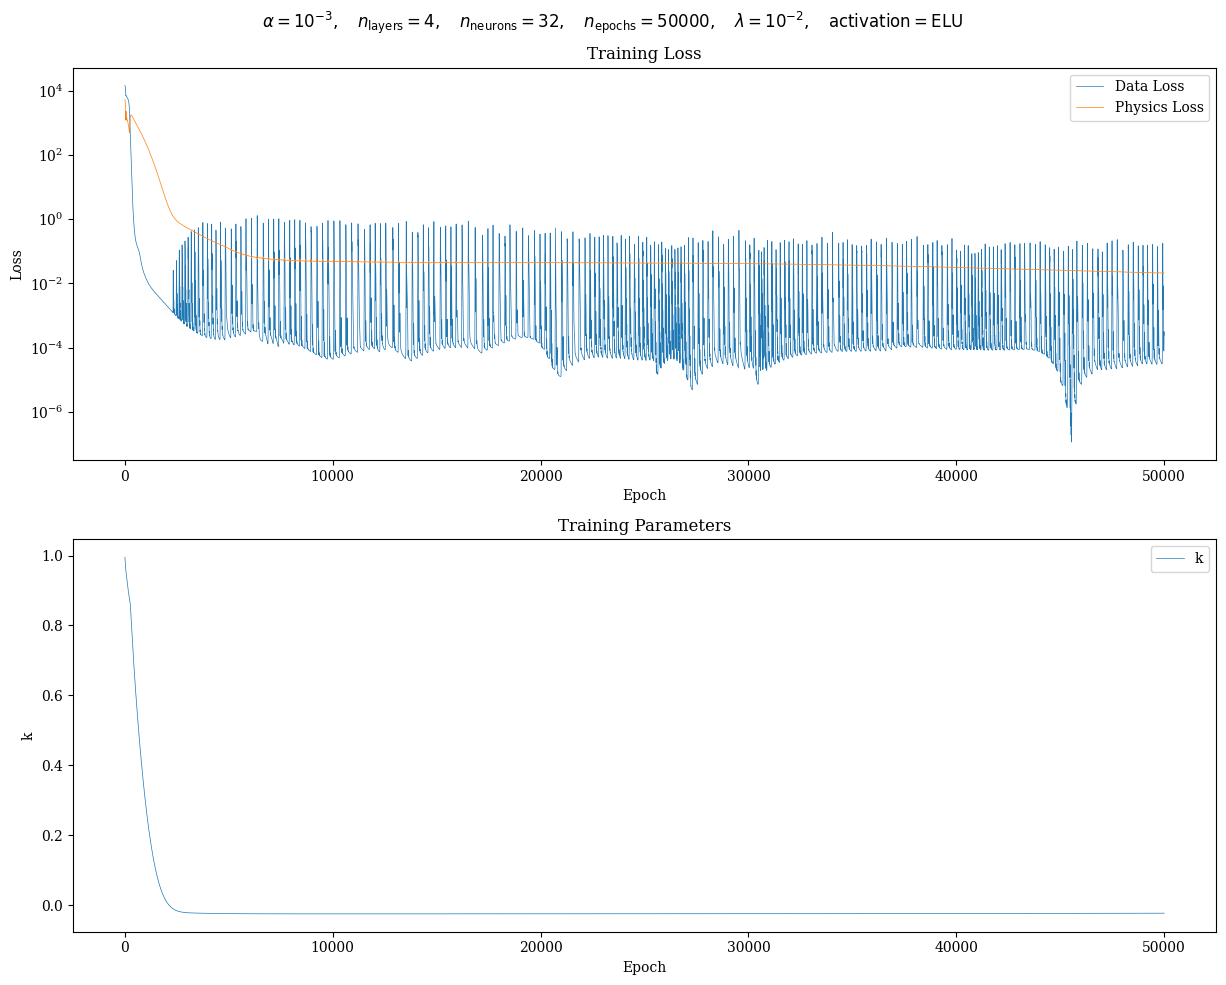

In [122]:
fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss",  ax=ax1, label="Data Loss", linewidth=0.5)
pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", ax=ax1, label="Physics Loss", linewidth=0.5)

pd.DataFrame(plot_loss_train).plot(x="epoch", y="k", ax=ax2, label="k", linewidth=0.5)

ax1.set_xlabel(r"Epoch")
ax1.set_ylabel(r"Loss")
ax1.set_title(r"Training Loss")
ax1.set_yscale('log')
ax1.legend()

ax2.set_xlabel(r"Epoch")
ax2.set_ylabel(r"k")
ax2.set_title(r"Training Parameters")
ax2.legend()

plt.suptitle(r"$\alpha=10^{-3},\quad n_{\text{layers}}=4,\quad n_{\text{neurons}}=32,\quad n_{\text{epochs}}=50000, \quad \lambda=10^{-2}, \quad \text{activation}=\text{ELU}$")
plt.tight_layout()
plt.savefig(f"{folder_path}/training_loss.png", dpi=300)

pd.DataFrame(x_train.cpu().numpy(), columns=["time"]).to_parquet(f"{folder_path}/x_train.parquet")
pd.DataFrame(y_train.cpu().numpy(), columns=["temperature"]).to_parquet(f"{folder_path}/y_train.parquet")

torch.save(model, f"{folder_path}/pinn_model.pth")
torch.save(model.state_dict(), f"{folder_path}/pinn_weights.pth")

## results

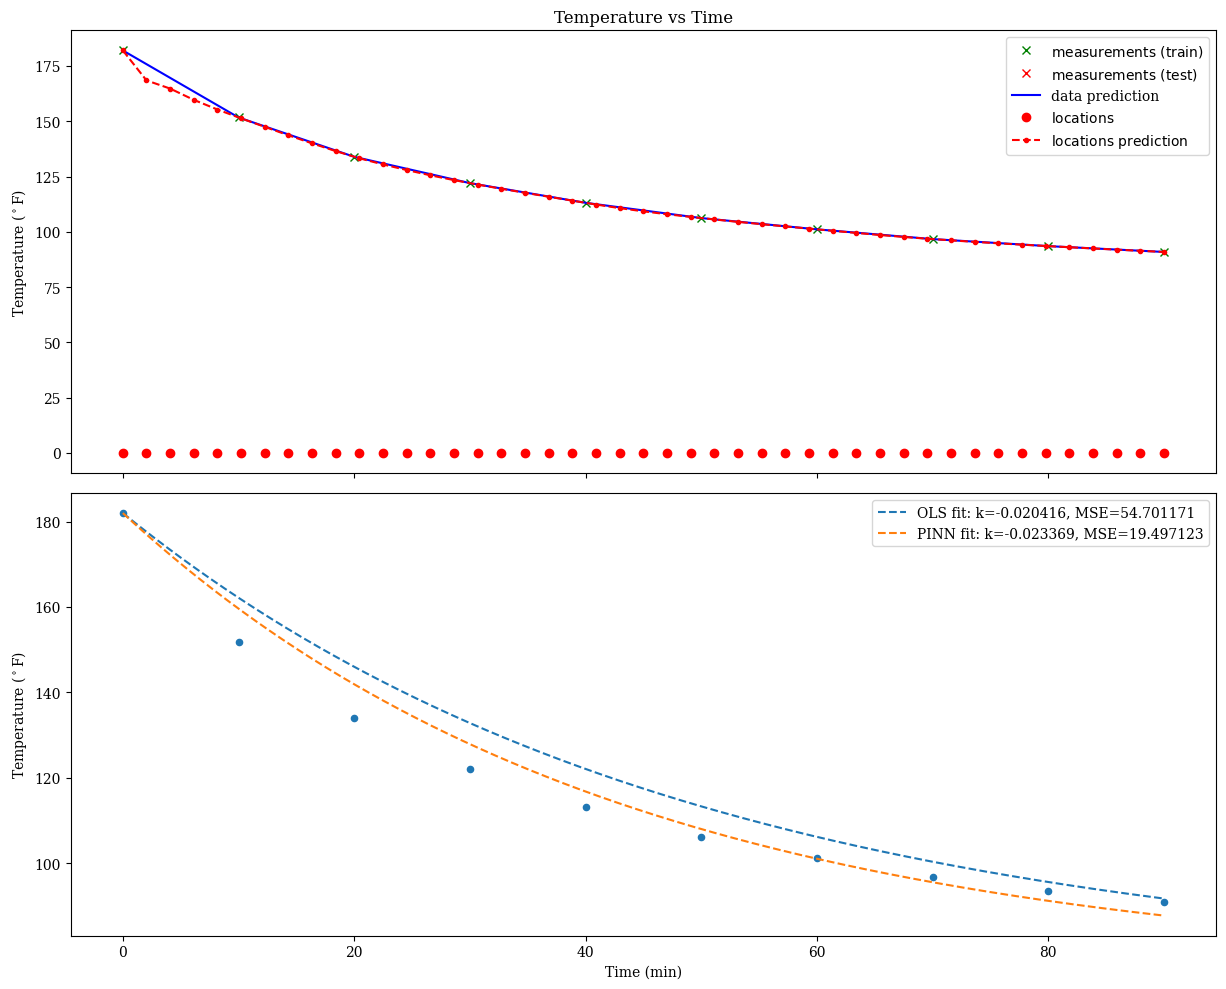

In [124]:
fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10), sharex=True)

model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

X.query(f"time <= {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query(f"time > {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"data prediction"
) 

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
) 

# ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Temperature ($^\circ$F)")
ax1.set_title("Temperature vs Time")
ax1.legend()


X.plot.scatter(x='time', y='temperature', ax=ax2)
t = np.linspace(0, 90, 1000)

T = (X['temperature'][0] - S) * np.exp(k * t) + S
_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(k * X['time']) + S)
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"OLS fit: k={k:.6f}, MSE={_mse:.6f}",
) 

_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(_k.item() * X['time']) + S)
T = (X['temperature'][0] - S) * np.exp(_k.item() * t) + S
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"PINN fit: k={_k.item():.6f}, MSE={_mse:.6f}",
) 

ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature ($^\circ$F)")
ax2.legend()

plt.tight_layout()

plt.savefig(f"{folder_path}/temperature_vs_time_with_prediction.png", dpi=300)

# experimentos

## relu

In [104]:
_locations = torch.linspace(0, 90, 45).view(-1,1).requires_grad_(True).to(device)
_S = torch.tensor(S, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(1.0, dtype=torch.float, requires_grad=True, device=device)
_T0 = torch.tensor(X["temperature"][0], dtype=torch.float, requires_grad=False).to(device)

# model = MultiLayerPerceptronRegressor(architecture, nn.LeakyReLU)
# model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
model = MultiLayerPerceptronRegressor(architecture, nn.ReLU)
model.to(device)
optimizer = optim.Adam([
    {"params": model.parameters()}, 
    {"params": [_k]}
], lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], k=[])

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]

    _diff_equation = dydt - _k * (y_location_hat - _S)

    physics_loss = torch.mean(_diff_equation**2)
    _T0_loss = criterion(y_location_hat[0], _T0)

    loss = data_loss + (1e-2)*(physics_loss + _T0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, T0 Loss: {_T0_loss.item():.6f}, Total Loss: {loss.item():.6f}")
        print(f"k: {_k.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())
        plot_loss_train["k"].append(_k.item())

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|          | 0/50000 [00:00<?, ?it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1030/50000 [00:04<03:27, 236.34it/s]

Data Loss: 0.675003, Physics Loss: 243.956238, T0 Loss: 0.036153, Total Loss: 3.114926
k: 0.299189


  4%|▍         | 2034/50000 [00:08<03:16, 244.72it/s]

Data Loss: 0.002622, Physics Loss: 3.380445, T0 Loss: 0.000045, Total Loss: 0.036427
k: 0.001737


  6%|▌         | 3034/50000 [00:12<03:14, 241.14it/s]

Data Loss: 1.329103, Physics Loss: 1.646601, T0 Loss: 0.002924, Total Loss: 1.345598
k: -0.023542


  8%|▊         | 4048/50000 [00:16<03:08, 243.31it/s]

Data Loss: 0.003340, Physics Loss: 0.954058, T0 Loss: 0.000045, Total Loss: 0.012881
k: -0.021081


 10%|█         | 5035/50000 [00:20<03:07, 240.22it/s]

Data Loss: 0.001804, Physics Loss: 0.573977, T0 Loss: 0.000004, Total Loss: 0.007543
k: -0.023933


 12%|█▏        | 6027/50000 [00:24<02:57, 247.37it/s]

Data Loss: 0.000126, Physics Loss: 0.566685, T0 Loss: 0.000000, Total Loss: 0.005793
k: -0.027316


 14%|█▍        | 7036/50000 [00:28<02:55, 244.39it/s]

Data Loss: 0.006194, Physics Loss: 0.545143, T0 Loss: 0.000001, Total Loss: 0.011645
k: -0.027725


 16%|█▌        | 8020/50000 [00:32<02:36, 268.18it/s]

Data Loss: 16.707836, Physics Loss: 0.664283, T0 Loss: 0.114573, Total Loss: 16.715624
k: -0.028895


 18%|█▊        | 9034/50000 [00:35<02:48, 243.65it/s]

Data Loss: 1.479605, Physics Loss: 0.521229, T0 Loss: 0.016098, Total Loss: 1.484979
k: -0.027640


 20%|██        | 10046/50000 [00:39<02:11, 303.85it/s]

Data Loss: 0.000899, Physics Loss: 0.527743, T0 Loss: 0.000002, Total Loss: 0.006176
k: -0.027852


 22%|██▏       | 11043/50000 [00:43<02:39, 244.61it/s]

Data Loss: 0.000405, Physics Loss: 0.525029, T0 Loss: 0.000000, Total Loss: 0.005655
k: -0.028042


 24%|██▍       | 12045/50000 [00:47<02:13, 284.56it/s]

Data Loss: 0.002153, Physics Loss: 0.481488, T0 Loss: 0.000001, Total Loss: 0.006967
k: -0.027427


 26%|██▌       | 13030/50000 [00:50<01:46, 346.55it/s]

Data Loss: 0.000197, Physics Loss: 0.478776, T0 Loss: 0.000001, Total Loss: 0.004985
k: -0.027482


 28%|██▊       | 14034/50000 [00:52<01:31, 392.30it/s]

Data Loss: 0.260599, Physics Loss: 0.520508, T0 Loss: 0.000000, Total Loss: 0.265804
k: -0.026530


 30%|███       | 15052/50000 [00:55<01:59, 292.75it/s]

Data Loss: 0.001537, Physics Loss: 0.474380, T0 Loss: 0.000001, Total Loss: 0.006280
k: -0.027231


 32%|███▏      | 16040/50000 [00:59<02:07, 266.51it/s]

Data Loss: 0.001239, Physics Loss: 0.460553, T0 Loss: 0.000001, Total Loss: 0.005845
k: -0.027176


 34%|███▍      | 17045/50000 [01:02<01:46, 309.08it/s]

Data Loss: 0.006209, Physics Loss: 0.467714, T0 Loss: 0.000000, Total Loss: 0.010886
k: -0.027263


 36%|███▌      | 18040/50000 [01:04<01:24, 376.76it/s]

Data Loss: 1.196340, Physics Loss: 0.532113, T0 Loss: 0.026023, Total Loss: 1.201922
k: -0.027068


 38%|███▊      | 19063/50000 [01:07<01:22, 377.26it/s]

Data Loss: 0.001095, Physics Loss: 0.649364, T0 Loss: 0.000000, Total Loss: 0.007589
k: -0.027765


 40%|████      | 20030/50000 [01:11<02:06, 236.23it/s]

Data Loss: 0.000756, Physics Loss: 0.405862, T0 Loss: 0.000001, Total Loss: 0.004815
k: -0.025099


 42%|████▏     | 21048/50000 [01:15<01:57, 245.38it/s]

Data Loss: 0.001051, Physics Loss: 0.423937, T0 Loss: 0.000015, Total Loss: 0.005290
k: -0.024538


 44%|████▍     | 22041/50000 [01:19<01:55, 241.04it/s]

Data Loss: 0.069996, Physics Loss: 0.394461, T0 Loss: 0.006233, Total Loss: 0.074003
k: -0.025299


 46%|████▌     | 23041/50000 [01:24<01:50, 244.42it/s]

Data Loss: 0.002838, Physics Loss: 0.378546, T0 Loss: 0.000001, Total Loss: 0.006624
k: -0.025590


 48%|████▊     | 24032/50000 [01:27<01:44, 248.72it/s]

Data Loss: 0.030261, Physics Loss: 0.361252, T0 Loss: 0.000656, Total Loss: 0.033880
k: -0.025420


 50%|█████     | 25049/50000 [01:30<01:06, 377.57it/s]

Data Loss: 0.337231, Physics Loss: 0.395512, T0 Loss: 0.012774, Total Loss: 0.341314
k: -0.025470


 52%|█████▏    | 26064/50000 [01:33<00:53, 446.15it/s]

Data Loss: 0.005444, Physics Loss: 0.378567, T0 Loss: 0.000024, Total Loss: 0.009230
k: -0.024870


 54%|█████▍    | 27037/50000 [01:35<00:59, 384.52it/s]

Data Loss: 0.000000, Physics Loss: 0.618803, T0 Loss: 0.000000, Total Loss: 0.006188
k: -0.022303


 56%|█████▌    | 28033/50000 [01:39<01:32, 237.41it/s]

Data Loss: 0.024566, Physics Loss: 0.592026, T0 Loss: 0.000882, Total Loss: 0.030495
k: -0.022069


 58%|█████▊    | 29037/50000 [01:43<01:25, 245.23it/s]

Data Loss: 0.000780, Physics Loss: 0.564592, T0 Loss: 0.000007, Total Loss: 0.006426
k: -0.022242


 60%|██████    | 30033/50000 [01:47<01:25, 233.94it/s]

Data Loss: 0.500845, Physics Loss: 0.363019, T0 Loss: 0.012323, Total Loss: 0.504598
k: -0.023287


 62%|██████▏   | 31045/50000 [01:51<01:13, 257.10it/s]

Data Loss: 0.104604, Physics Loss: 0.275133, T0 Loss: 0.002792, Total Loss: 0.107384
k: -0.021640


 64%|██████▍   | 32032/50000 [01:55<01:13, 244.04it/s]

Data Loss: 0.044451, Physics Loss: 0.235066, T0 Loss: 0.001218, Total Loss: 0.046814
k: -0.023167


 66%|██████▌   | 33045/50000 [01:59<01:10, 239.87it/s]

Data Loss: 0.982460, Physics Loss: 0.224896, T0 Loss: 0.024366, Total Loss: 0.984953
k: -0.023141


 68%|██████▊   | 34027/50000 [02:03<01:05, 242.87it/s]

Data Loss: 0.066830, Physics Loss: 0.209449, T0 Loss: 0.000006, Total Loss: 0.068924
k: -0.023663


 70%|███████   | 35044/50000 [02:07<00:59, 251.71it/s]

Data Loss: 0.049140, Physics Loss: 0.214239, T0 Loss: 0.001401, Total Loss: 0.051297
k: -0.023013


 72%|███████▏  | 36045/50000 [02:11<00:50, 274.73it/s]

Data Loss: 0.028625, Physics Loss: 0.201243, T0 Loss: 0.000850, Total Loss: 0.030646
k: -0.022985


 74%|███████▍  | 37048/50000 [02:15<00:47, 274.55it/s]

Data Loss: 0.038737, Physics Loss: 0.169435, T0 Loss: 0.003174, Total Loss: 0.040463
k: -0.022930


 76%|███████▌  | 38053/50000 [02:18<00:41, 284.59it/s]

Data Loss: 0.000016, Physics Loss: 0.177552, T0 Loss: 0.000000, Total Loss: 0.001792
k: -0.023383


 78%|███████▊  | 39057/50000 [02:22<00:27, 396.93it/s]

Data Loss: 0.063691, Physics Loss: 0.144453, T0 Loss: 0.002004, Total Loss: 0.065156
k: -0.023573


 80%|████████  | 40060/50000 [02:25<00:26, 370.83it/s]

Data Loss: 0.006402, Physics Loss: 0.126981, T0 Loss: 0.000225, Total Loss: 0.007674
k: -0.024119


 82%|████████▏ | 41042/50000 [02:28<00:26, 331.90it/s]

Data Loss: 0.000649, Physics Loss: 0.129326, T0 Loss: 0.000016, Total Loss: 0.001942
k: -0.023498


 84%|████████▍ | 42045/50000 [02:32<00:33, 240.09it/s]

Data Loss: 0.001028, Physics Loss: 0.089856, T0 Loss: 0.000030, Total Loss: 0.001927
k: -0.023122


 86%|████████▌ | 43029/50000 [02:36<00:29, 240.09it/s]

Data Loss: 0.000701, Physics Loss: 0.080217, T0 Loss: 0.000000, Total Loss: 0.001503
k: -0.023066


 88%|████████▊ | 44044/50000 [02:40<00:24, 244.92it/s]

Data Loss: 0.001526, Physics Loss: 0.074042, T0 Loss: 0.000042, Total Loss: 0.002267
k: -0.023037


 90%|█████████ | 45025/50000 [02:44<00:19, 249.96it/s]

Data Loss: 0.026960, Physics Loss: 0.110245, T0 Loss: 0.001128, Total Loss: 0.028074
k: -0.022746


 92%|█████████▏| 46028/50000 [02:48<00:16, 246.88it/s]

Data Loss: 0.000341, Physics Loss: 0.199232, T0 Loss: 0.000000, Total Loss: 0.002334
k: -0.020311


 94%|█████████▍| 47060/50000 [02:52<00:09, 313.29it/s]

Data Loss: 0.000516, Physics Loss: 0.645615, T0 Loss: 0.000001, Total Loss: 0.006972
k: -0.022606


 96%|█████████▌| 48051/50000 [02:55<00:06, 281.03it/s]

Data Loss: 0.000613, Physics Loss: 0.392702, T0 Loss: 0.000000, Total Loss: 0.004540
k: -0.022505


 98%|█████████▊| 49034/50000 [02:58<00:03, 275.80it/s]

Data Loss: 0.000901, Physics Loss: 0.242588, T0 Loss: 0.000023, Total Loss: 0.003327
k: -0.023445


100%|██████████| 50000/50000 [03:02<00:00, 274.63it/s]

Data Loss: 0.000405, Physics Loss: 0.172706, T0 Loss: 0.000008, Total Loss: 0.002132
k: -0.023469


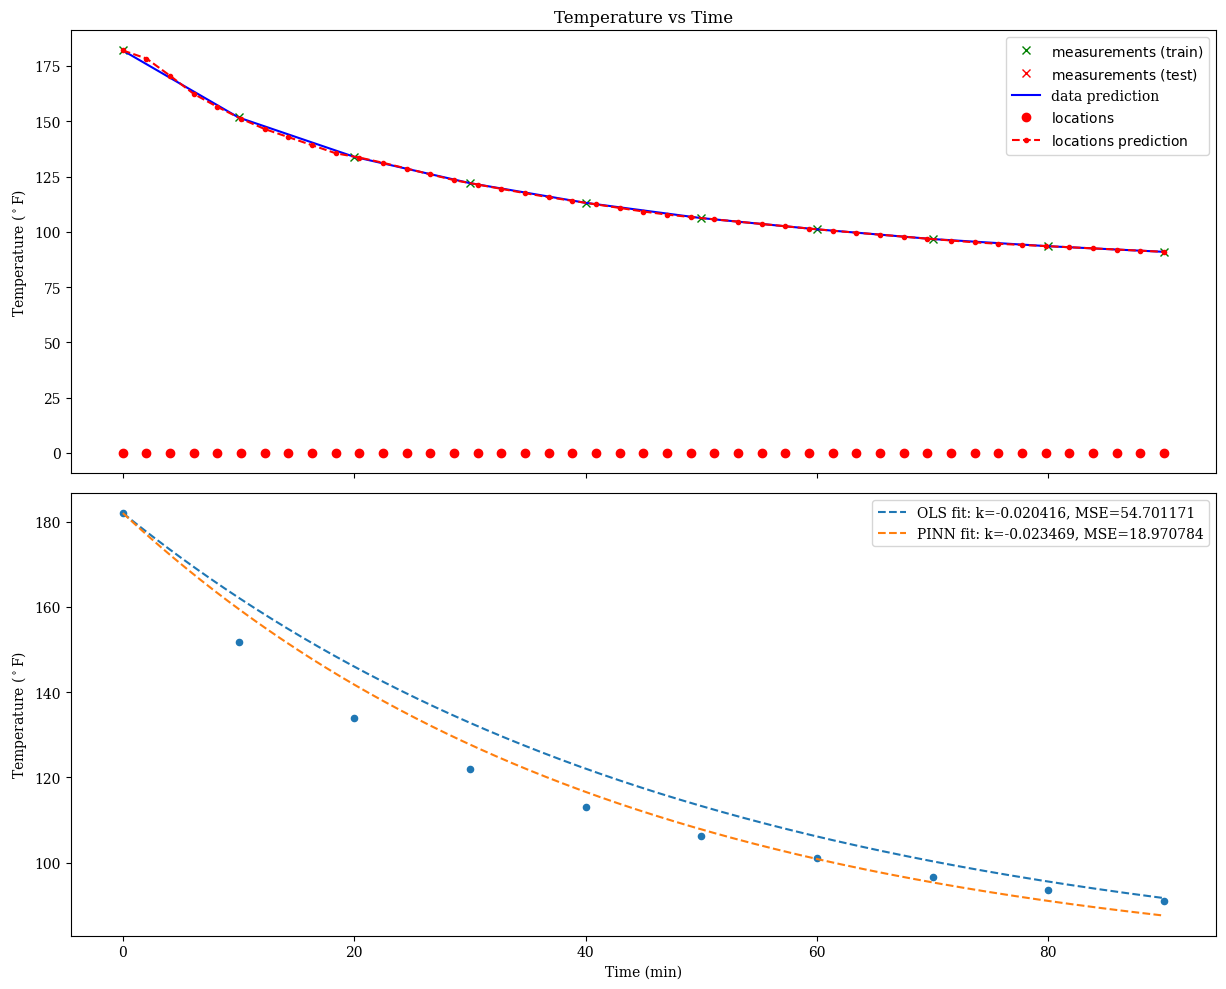

In [105]:
fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10), sharex=True)

model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

X.query(f"time <= {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query(f"time > {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"data prediction"
) 

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
) 

# ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Temperature ($^\circ$F)")
ax1.set_title("Temperature vs Time")
ax1.legend()


X.plot.scatter(x='time', y='temperature', ax=ax2)
t = np.linspace(0, 90, 1000)

T = (X['temperature'][0] - S) * np.exp(k * t) + S
_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(k * X['time']) + S)
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"OLS fit: k={k:.6f}, MSE={_mse:.6f}",
) 

_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(_k.item() * X['time']) + S)
T = (X['temperature'][0] - S) * np.exp(_k.item() * t) + S
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"PINN fit: k={_k.item():.6f}, MSE={_mse:.6f}",
) 

ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature ($^\circ$F)")
ax2.legend()

plt.tight_layout()

### batch normalization

In [106]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(nn.BatchNorm1d(layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;

_locations = torch.linspace(0, 90, 45).view(-1,1).requires_grad_(True).to(device)
_S = torch.tensor(S, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(1.0, dtype=torch.float, requires_grad=True, device=device)
_T0 = torch.tensor(X["temperature"][0], dtype=torch.float, requires_grad=False).to(device)

# model = MultiLayerPerceptronRegressor(architecture, nn.LeakyReLU)
# model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
model = MultiLayerPerceptronRegressor(architecture, nn.ReLU)
model.to(device)
optimizer = optim.Adam([
    {"params": model.parameters()}, 
    {"params": [_k]}
], lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], k=[])

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]

    _diff_equation = dydt - _k * (y_location_hat - _S)

    physics_loss = torch.mean(_diff_equation**2)
    _T0_loss = criterion(y_location_hat[0], _T0)

    loss = data_loss + (1e-2)*(physics_loss + _T0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, T0 Loss: {_T0_loss.item():.6f}, Total Loss: {loss.item():.6f}")
        print(f"k: {_k.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())
        plot_loss_train["k"].append(_k.item())

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|          | 0/50000 [00:00<?, ?it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1029/50000 [00:05<03:58, 204.91it/s]

Data Loss: 2747.839600, Physics Loss: 96.556610, T0 Loss: 6.156132, Total Loss: 2748.866699
k: 0.467335


  4%|▍         | 2035/50000 [00:10<04:16, 187.12it/s]

Data Loss: 1.953085, Physics Loss: 84.271919, T0 Loss: 0.164766, Total Loss: 2.797452
k: 0.180552


  6%|▌         | 3019/50000 [00:15<03:57, 197.50it/s]

Data Loss: 0.000017, Physics Loss: 3.099526, T0 Loss: 0.000001, Total Loss: 0.031012
k: 0.011599


  8%|▊         | 4026/50000 [00:21<03:42, 206.40it/s]

Data Loss: 0.000000, Physics Loss: 0.722544, T0 Loss: 0.000258, Total Loss: 0.007229
k: 0.000845


 10%|█         | 5038/50000 [00:26<03:39, 205.04it/s]

Data Loss: 0.000001, Physics Loss: 0.712890, T0 Loss: 0.000017, Total Loss: 0.007130
k: 0.000483


 12%|█▏        | 6015/50000 [00:33<04:03, 180.83it/s]

Data Loss: 0.004476, Physics Loss: 0.622667, T0 Loss: 0.042540, Total Loss: 0.011128
k: 0.000245


 14%|█▍        | 7028/50000 [00:38<03:17, 217.92it/s]

Data Loss: 0.000253, Physics Loss: 0.483146, T0 Loss: 0.002266, Total Loss: 0.005107
k: 0.000677


 16%|█▌        | 8021/50000 [00:43<03:17, 212.30it/s]

Data Loss: 0.000001, Physics Loss: 0.612616, T0 Loss: 0.000007, Total Loss: 0.006128
k: 0.000793


 18%|█▊        | 9037/50000 [00:48<03:19, 205.40it/s]

Data Loss: 0.000653, Physics Loss: 0.518129, T0 Loss: 0.006442, Total Loss: 0.005898
k: 0.000734


 20%|██        | 10022/50000 [00:54<04:00, 166.48it/s]

Data Loss: 0.002052, Physics Loss: 0.498523, T0 Loss: 0.158582, Total Loss: 0.008623
k: 0.001081


 22%|██▏       | 11029/50000 [01:00<03:20, 193.91it/s]

Data Loss: 0.000031, Physics Loss: 0.398824, T0 Loss: 0.000004, Total Loss: 0.004020
k: 0.000774


 24%|██▍       | 12030/50000 [01:05<02:50, 222.30it/s]

Data Loss: 0.008250, Physics Loss: 0.588179, T0 Loss: 0.034269, Total Loss: 0.014475
k: 0.001128


 26%|██▌       | 13027/50000 [01:10<03:43, 165.11it/s]

Data Loss: 0.000009, Physics Loss: 0.431853, T0 Loss: 0.000048, Total Loss: 0.004328
k: 0.001264


 28%|██▊       | 14019/50000 [01:15<03:31, 170.11it/s]

Data Loss: 0.000230, Physics Loss: 0.362550, T0 Loss: 0.001087, Total Loss: 0.003866
k: 0.000899


 30%|███       | 15032/50000 [01:21<03:14, 179.95it/s]

Data Loss: 0.000018, Physics Loss: 0.402253, T0 Loss: 0.000011, Total Loss: 0.004041
k: 0.000859


 32%|███▏      | 16039/50000 [01:26<02:43, 208.00it/s]

Data Loss: 0.000013, Physics Loss: 0.385239, T0 Loss: 0.000010, Total Loss: 0.003865
k: 0.001033


 34%|███▍      | 17013/50000 [01:31<03:14, 169.58it/s]

Data Loss: 0.000022, Physics Loss: 0.264130, T0 Loss: 0.000082, Total Loss: 0.002664
k: 0.000890


 36%|███▌      | 18012/50000 [01:37<04:19, 123.06it/s]

Data Loss: 0.000182, Physics Loss: 0.454740, T0 Loss: 0.000048, Total Loss: 0.004730
k: 0.000616


 38%|███▊      | 19023/50000 [01:45<04:15, 121.17it/s]

Data Loss: 0.000013, Physics Loss: 0.591224, T0 Loss: 0.000082, Total Loss: 0.005926
k: 0.000932


 40%|████      | 20015/50000 [01:52<04:05, 122.26it/s]

Data Loss: 0.000051, Physics Loss: 0.410055, T0 Loss: 0.000147, Total Loss: 0.004153
k: 0.000522


 42%|████▏     | 21014/50000 [02:00<03:22, 143.17it/s]

Data Loss: 0.000024, Physics Loss: 0.379225, T0 Loss: 0.000155, Total Loss: 0.003818
k: 0.000433


 44%|████▍     | 22027/50000 [02:08<03:27, 134.72it/s]

Data Loss: 0.003252, Physics Loss: 0.423934, T0 Loss: 0.003954, Total Loss: 0.007530
k: 0.000561


 46%|████▌     | 23020/50000 [02:15<03:40, 122.42it/s]

Data Loss: 0.000001, Physics Loss: 0.356231, T0 Loss: 0.000004, Total Loss: 0.003563
k: 0.000479


 48%|████▊     | 24019/50000 [02:23<03:26, 125.93it/s]

Data Loss: 0.000007, Physics Loss: 0.261839, T0 Loss: 0.000004, Total Loss: 0.002625
k: 0.000388


 50%|█████     | 25019/50000 [02:32<03:29, 119.51it/s]

Data Loss: 0.001336, Physics Loss: 0.312862, T0 Loss: 0.000012, Total Loss: 0.004465
k: 0.000304


 52%|█████▏    | 26022/50000 [02:38<02:28, 161.42it/s]

Data Loss: 0.019141, Physics Loss: 0.326134, T0 Loss: 0.070573, Total Loss: 0.023108
k: 0.000310


 54%|█████▍    | 27017/50000 [02:46<02:45, 139.26it/s]

Data Loss: 0.007137, Physics Loss: 0.412912, T0 Loss: 0.014093, Total Loss: 0.011407
k: 0.000183


 56%|█████▌    | 28033/50000 [02:51<01:46, 207.06it/s]

Data Loss: 0.000000, Physics Loss: 0.298111, T0 Loss: 0.000154, Total Loss: 0.002983
k: 0.000560


 58%|█████▊    | 29027/50000 [02:56<01:40, 209.07it/s]

Data Loss: 0.017529, Physics Loss: 0.293438, T0 Loss: 0.029342, Total Loss: 0.020757
k: 0.000699


 60%|██████    | 30027/50000 [03:01<01:47, 185.64it/s]

Data Loss: 0.002677, Physics Loss: 0.263764, T0 Loss: 0.021409, Total Loss: 0.005529
k: 0.000670


 62%|██████▏   | 31041/50000 [03:07<01:33, 203.56it/s]

Data Loss: 0.033603, Physics Loss: 0.263633, T0 Loss: 0.489932, Total Loss: 0.041138
k: 0.000501


 64%|██████▍   | 32028/50000 [03:12<01:36, 186.65it/s]

Data Loss: 0.002427, Physics Loss: 0.233824, T0 Loss: 0.011661, Total Loss: 0.004882
k: 0.000481


 66%|██████▌   | 33016/50000 [03:18<01:48, 155.93it/s]

Data Loss: 0.000021, Physics Loss: 0.258283, T0 Loss: 0.000024, Total Loss: 0.002604
k: 0.000424


 68%|██████▊   | 34022/50000 [03:23<01:16, 209.76it/s]

Data Loss: 0.000000, Physics Loss: 0.318382, T0 Loss: 0.000036, Total Loss: 0.003184
k: 0.000266


 70%|███████   | 35016/50000 [03:30<02:05, 119.29it/s]

Data Loss: 0.000009, Physics Loss: 0.244085, T0 Loss: 0.000045, Total Loss: 0.002450
k: 0.000369


 72%|███████▏  | 36016/50000 [03:38<01:47, 129.97it/s]

Data Loss: 0.000019, Physics Loss: 0.246353, T0 Loss: 0.000237, Total Loss: 0.002484
k: 0.000316


 74%|███████▍  | 37021/50000 [03:45<01:46, 121.40it/s]

Data Loss: 0.003000, Physics Loss: 0.210641, T0 Loss: 0.000238, Total Loss: 0.005108
k: 0.000391


 76%|███████▌  | 38025/50000 [03:52<01:27, 136.15it/s]

Data Loss: 0.000000, Physics Loss: 0.266251, T0 Loss: 0.000023, Total Loss: 0.002663
k: 0.000272


 78%|███████▊  | 39014/50000 [04:00<01:31, 119.70it/s]

Data Loss: 0.000000, Physics Loss: 0.259184, T0 Loss: 0.000000, Total Loss: 0.002592
k: 0.000321


 80%|████████  | 40024/50000 [04:07<01:15, 131.74it/s]

Data Loss: 0.000211, Physics Loss: 0.191933, T0 Loss: 0.000199, Total Loss: 0.002133
k: 0.000347


 82%|████████▏ | 41012/50000 [04:15<01:15, 118.83it/s]

Data Loss: 0.002505, Physics Loss: 0.219907, T0 Loss: 0.001973, Total Loss: 0.004723
k: 0.000417


 84%|████████▍ | 42017/50000 [04:23<00:55, 142.98it/s]

Data Loss: 0.000488, Physics Loss: 0.197081, T0 Loss: 0.001701, Total Loss: 0.002475
k: 0.000263


 86%|████████▌ | 43025/50000 [04:29<00:33, 209.37it/s]

Data Loss: 0.000030, Physics Loss: 0.182790, T0 Loss: 0.000184, Total Loss: 0.001859
k: 0.000361


 88%|████████▊ | 44023/50000 [04:35<00:30, 199.20it/s]

Data Loss: 0.000794, Physics Loss: 0.209793, T0 Loss: 0.000671, Total Loss: 0.002899
k: 0.000450


 90%|█████████ | 45023/50000 [04:41<00:24, 205.05it/s]

Data Loss: 0.000009, Physics Loss: 0.191655, T0 Loss: 0.000121, Total Loss: 0.001927
k: 0.000558


 92%|█████████▏| 46017/50000 [04:46<00:24, 159.56it/s]

Data Loss: 0.000029, Physics Loss: 0.229613, T0 Loss: 0.000020, Total Loss: 0.002325
k: 0.000610


 94%|█████████▍| 47027/50000 [04:51<00:14, 210.26it/s]

Data Loss: 0.000059, Physics Loss: 0.210818, T0 Loss: 0.000667, Total Loss: 0.002174
k: 0.000606


 96%|█████████▌| 48021/50000 [04:56<00:09, 200.51it/s]

Data Loss: 0.000000, Physics Loss: 0.192419, T0 Loss: 0.000043, Total Loss: 0.001925
k: 0.000709


 98%|█████████▊| 49041/50000 [05:03<00:04, 197.67it/s]

Data Loss: 0.000053, Physics Loss: 0.172286, T0 Loss: 0.000016, Total Loss: 0.001776
k: 0.000703


100%|██████████| 50000/50000 [05:08<00:00, 162.12it/s]

Data Loss: 0.107087, Physics Loss: 0.180913, T0 Loss: 0.138448, Total Loss: 0.110280
k: 0.000565


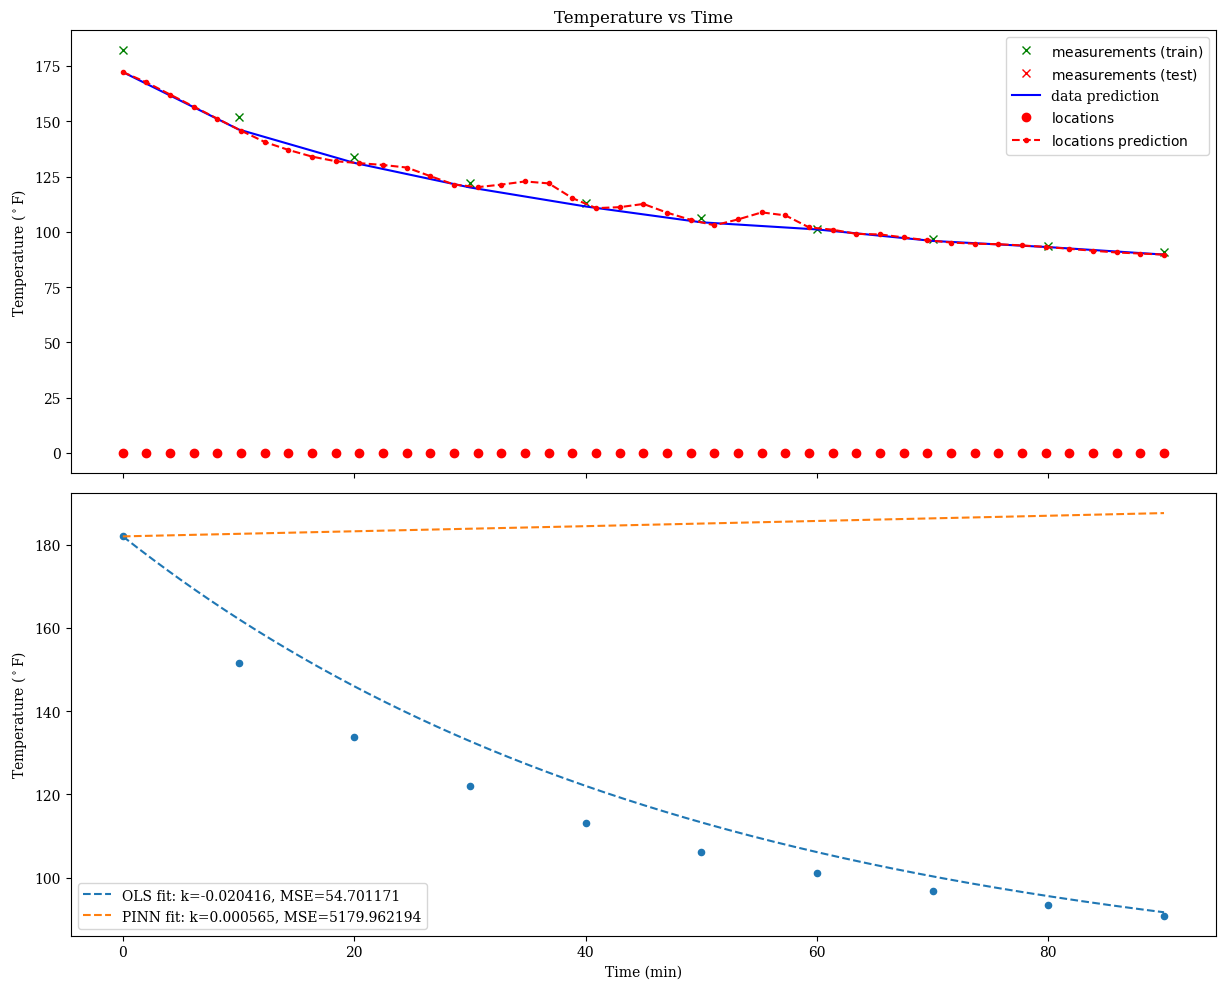

In [107]:
fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10), sharex=True)

model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

X.query(f"time <= {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query(f"time > {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"data prediction"
) 

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
) 

# ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Temperature ($^\circ$F)")
ax1.set_title("Temperature vs Time")
ax1.legend()


X.plot.scatter(x='time', y='temperature', ax=ax2)
t = np.linspace(0, 90, 1000)

T = (X['temperature'][0] - S) * np.exp(k * t) + S
_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(k * X['time']) + S)
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"OLS fit: k={k:.6f}, MSE={_mse:.6f}",
) 

_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(_k.item() * X['time']) + S)
T = (X['temperature'][0] - S) * np.exp(_k.item() * t) + S
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"PINN fit: k={_k.item():.6f}, MSE={_mse:.6f}",
) 

ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature ($^\circ$F)")
ax2.legend()

plt.tight_layout()

## leaky relu

In [108]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            # _architecture.append(nn.BatchNorm1d(layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;

_locations = torch.linspace(0, 90, 45).view(-1,1).requires_grad_(True).to(device)
_S = torch.tensor(S, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(1.0, dtype=torch.float, requires_grad=True, device=device)
_T0 = torch.tensor(X["temperature"][0], dtype=torch.float, requires_grad=False).to(device)

model = MultiLayerPerceptronRegressor(architecture, nn.LeakyReLU)
# model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
# model = MultiLayerPerceptronRegressor(architecture, nn.ReLU)
model.to(device)
optimizer = optim.Adam([
    {"params": model.parameters()}, 
    {"params": [_k]}
], lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], k=[])

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]

    _diff_equation = dydt - _k * (y_location_hat - _S)

    physics_loss = torch.mean(_diff_equation**2)
    _T0_loss = criterion(y_location_hat[0], _T0)

    loss = data_loss + (1e-2)*(physics_loss + _T0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, T0 Loss: {_T0_loss.item():.6f}, Total Loss: {loss.item():.6f}")
        print(f"k: {_k.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())
        plot_loss_train["k"].append(_k.item())

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|          | 0/50000 [00:00<?, ?it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1030/50000 [00:04<03:25, 237.97it/s]

Data Loss: 1.897245, Physics Loss: 351.371185, T0 Loss: 0.014362, Total Loss: 5.411100
k: 0.322911


  4%|▍         | 2038/50000 [00:08<03:17, 242.93it/s]

Data Loss: 1.689145, Physics Loss: 40.005516, T0 Loss: 0.001858, Total Loss: 2.089219
k: -0.007911


  6%|▌         | 3046/50000 [00:11<02:15, 345.28it/s]

Data Loss: 0.890833, Physics Loss: 30.251574, T0 Loss: 0.000908, Total Loss: 1.193358
k: -0.056958


  8%|▊         | 4079/50000 [00:14<01:58, 388.27it/s]

Data Loss: 0.718273, Physics Loss: 26.246540, T0 Loss: 0.000273, Total Loss: 0.980741
k: -0.054632


 10%|█         | 5077/50000 [00:16<01:54, 392.16it/s]

Data Loss: 0.108396, Physics Loss: 21.874292, T0 Loss: 0.000269, Total Loss: 0.327141
k: -0.050774


 12%|█▏        | 6072/50000 [00:19<01:50, 397.07it/s]

Data Loss: 0.098913, Physics Loss: 19.933542, T0 Loss: 0.000326, Total Loss: 0.298251
k: -0.051723


 14%|█▍        | 7033/50000 [00:21<02:12, 325.15it/s]

Data Loss: 0.086728, Physics Loss: 16.720039, T0 Loss: 0.000125, Total Loss: 0.253930
k: -0.045573


 16%|█▌        | 8069/50000 [00:24<01:48, 387.38it/s]

Data Loss: 0.084495, Physics Loss: 12.972748, T0 Loss: 0.000061, Total Loss: 0.214223
k: -0.041889


 18%|█▊        | 9056/50000 [00:27<01:44, 390.57it/s]

Data Loss: 1.994147, Physics Loss: 10.146280, T0 Loss: 0.039276, Total Loss: 2.096003
k: -0.038516


 20%|██        | 10053/50000 [00:30<02:06, 315.67it/s]

Data Loss: 0.102608, Physics Loss: 7.448787, T0 Loss: 0.000025, Total Loss: 0.177096
k: -0.034482


 22%|██▏       | 11025/50000 [00:34<02:37, 247.79it/s]

Data Loss: 0.083188, Physics Loss: 6.545574, T0 Loss: 0.000054, Total Loss: 0.148644
k: -0.036027


 24%|██▍       | 12048/50000 [00:38<02:27, 256.89it/s]

Data Loss: 1.245558, Physics Loss: 4.247132, T0 Loss: 0.003975, Total Loss: 1.288069
k: -0.032863


 26%|██▌       | 13055/50000 [00:42<02:15, 272.31it/s]

Data Loss: 0.086226, Physics Loss: 2.470006, T0 Loss: 0.000053, Total Loss: 0.110927
k: -0.031841


 28%|██▊       | 14052/50000 [00:44<01:31, 394.87it/s]

Data Loss: 0.053528, Physics Loss: 1.697706, T0 Loss: 0.000003, Total Loss: 0.070505
k: -0.028305


 30%|███       | 15047/50000 [00:47<01:55, 303.07it/s]

Data Loss: 0.046001, Physics Loss: 1.333267, T0 Loss: 0.000016, Total Loss: 0.059334
k: -0.025312


 32%|███▏      | 16051/50000 [00:50<01:41, 333.26it/s]

Data Loss: 1.640957, Physics Loss: 1.091213, T0 Loss: 0.026527, Total Loss: 1.652134
k: -0.025117


 34%|███▍      | 17052/50000 [00:53<01:55, 286.06it/s]

Data Loss: 0.981070, Physics Loss: 0.889229, T0 Loss: 0.018880, Total Loss: 0.990151
k: -0.024937


 36%|███▌      | 18024/50000 [00:56<01:28, 359.48it/s]

Data Loss: 0.008666, Physics Loss: 0.738559, T0 Loss: 0.000024, Total Loss: 0.016051
k: -0.023817


 38%|███▊      | 19037/50000 [00:59<01:55, 267.62it/s]

Data Loss: 0.072980, Physics Loss: 0.612483, T0 Loss: 0.000616, Total Loss: 0.079111
k: -0.023836


 40%|████      | 20078/50000 [01:02<01:08, 438.97it/s]

Data Loss: 0.583918, Physics Loss: 0.501871, T0 Loss: 0.008413, Total Loss: 0.589021
k: -0.022794


 42%|████▏     | 21024/50000 [01:05<02:00, 240.94it/s]

Data Loss: 2.105428, Physics Loss: 0.463462, T0 Loss: 0.049393, Total Loss: 2.110556
k: -0.021980


 44%|████▍     | 22032/50000 [01:09<01:27, 320.01it/s]

Data Loss: 0.684029, Physics Loss: 0.406159, T0 Loss: 0.014096, Total Loss: 0.688231
k: -0.022038


 46%|████▌     | 23052/50000 [01:12<01:26, 310.38it/s]

Data Loss: 0.125797, Physics Loss: 0.341107, T0 Loss: 0.002828, Total Loss: 0.129236
k: -0.020912


 48%|████▊     | 24029/50000 [01:15<01:29, 288.92it/s]

Data Loss: 0.144038, Physics Loss: 0.323662, T0 Loss: 0.001569, Total Loss: 0.147290
k: -0.021107


 50%|█████     | 25037/50000 [01:19<01:44, 237.95it/s]

Data Loss: 2.879232, Physics Loss: 0.317253, T0 Loss: 0.068641, Total Loss: 2.883091
k: -0.021123


 52%|█████▏    | 26037/50000 [01:23<01:42, 234.83it/s]

Data Loss: 0.005522, Physics Loss: 0.303901, T0 Loss: 0.000090, Total Loss: 0.008562
k: -0.021287


 54%|█████▍    | 27025/50000 [01:27<01:34, 243.02it/s]

Data Loss: 0.000908, Physics Loss: 0.285409, T0 Loss: 0.000000, Total Loss: 0.003762
k: -0.021540


 56%|█████▌    | 28027/50000 [01:31<01:29, 244.76it/s]

Data Loss: 0.001149, Physics Loss: 0.275233, T0 Loss: 0.000000, Total Loss: 0.003902
k: -0.021772


 58%|█████▊    | 29068/50000 [01:34<00:49, 425.21it/s]

Data Loss: 0.002755, Physics Loss: 0.255170, T0 Loss: 0.000043, Total Loss: 0.005307
k: -0.021226


 60%|██████    | 30075/50000 [01:37<00:57, 347.25it/s]

Data Loss: 0.344741, Physics Loss: 0.246792, T0 Loss: 0.008116, Total Loss: 0.347290
k: -0.021613


 62%|██████▏   | 31038/50000 [01:40<01:06, 285.44it/s]

Data Loss: 0.055169, Physics Loss: 0.268405, T0 Loss: 0.000598, Total Loss: 0.057859
k: -0.021258


 64%|██████▍   | 32037/50000 [01:43<01:17, 231.86it/s]

Data Loss: 0.060726, Physics Loss: 0.245692, T0 Loss: 0.001667, Total Loss: 0.063200
k: -0.021171


 66%|██████▌   | 33052/50000 [01:48<01:02, 269.95it/s]

Data Loss: 0.257042, Physics Loss: 0.242742, T0 Loss: 0.005696, Total Loss: 0.259526
k: -0.021286


 68%|██████▊   | 34026/50000 [01:51<01:07, 235.81it/s]

Data Loss: 0.067371, Physics Loss: 0.229570, T0 Loss: 0.002036, Total Loss: 0.069687
k: -0.021472


 70%|███████   | 35037/50000 [01:56<01:03, 236.04it/s]

Data Loss: 0.016635, Physics Loss: 0.225959, T0 Loss: 0.000000, Total Loss: 0.018895
k: -0.021775


 72%|███████▏  | 36063/50000 [02:00<00:39, 350.71it/s]

Data Loss: 0.007401, Physics Loss: 0.216018, T0 Loss: 0.000000, Total Loss: 0.009561
k: -0.021609


 74%|███████▍  | 37028/50000 [02:03<00:52, 248.63it/s]

Data Loss: 0.002408, Physics Loss: 0.214212, T0 Loss: 0.000000, Total Loss: 0.004551
k: -0.021907


 76%|███████▌  | 38040/50000 [02:07<00:48, 245.01it/s]

Data Loss: 0.001707, Physics Loss: 0.195770, T0 Loss: 0.000004, Total Loss: 0.003664
k: -0.021881


 78%|███████▊  | 39071/50000 [02:10<00:25, 436.35it/s]

Data Loss: 0.014369, Physics Loss: 0.191086, T0 Loss: 0.000728, Total Loss: 0.016287
k: -0.021989


 80%|████████  | 40053/50000 [02:13<00:25, 387.12it/s]

Data Loss: 0.679389, Physics Loss: 0.189593, T0 Loss: 0.029799, Total Loss: 0.681583
k: -0.021795


 82%|████████▏ | 41038/50000 [02:16<00:33, 265.36it/s]

Data Loss: 0.001500, Physics Loss: 0.171942, T0 Loss: 0.000016, Total Loss: 0.003220
k: -0.021951


 84%|████████▍ | 42054/50000 [02:20<00:28, 277.76it/s]

Data Loss: 0.000628, Physics Loss: 0.167963, T0 Loss: 0.000001, Total Loss: 0.002308
k: -0.021885


 86%|████████▌ | 43035/50000 [02:24<00:24, 283.57it/s]

Data Loss: 0.443303, Physics Loss: 0.186520, T0 Loss: 0.024390, Total Loss: 0.445412
k: -0.021531


 88%|████████▊ | 44053/50000 [02:27<00:14, 414.28it/s]

Data Loss: 0.000325, Physics Loss: 0.181361, T0 Loss: 0.000000, Total Loss: 0.002139
k: -0.022692


 90%|█████████ | 45059/50000 [02:30<00:14, 345.34it/s]

Data Loss: 0.000805, Physics Loss: 0.170330, T0 Loss: 0.000000, Total Loss: 0.002508
k: -0.022577


 92%|█████████▏| 46032/50000 [02:34<00:15, 252.72it/s]

Data Loss: 0.000210, Physics Loss: 0.161077, T0 Loss: 0.000000, Total Loss: 0.001821
k: -0.022303


 94%|█████████▍| 47033/50000 [02:38<00:12, 244.86it/s]

Data Loss: 0.025096, Physics Loss: 0.179775, T0 Loss: 0.001136, Total Loss: 0.026906
k: -0.022952


 96%|█████████▌| 48034/50000 [02:42<00:07, 247.20it/s]

Data Loss: 0.000313, Physics Loss: 0.163458, T0 Loss: 0.000000, Total Loss: 0.001947
k: -0.023233


 98%|█████████▊| 49040/50000 [02:46<00:03, 246.04it/s]

Data Loss: 0.001118, Physics Loss: 0.145819, T0 Loss: 0.000000, Total Loss: 0.002576
k: -0.023555


100%|██████████| 50000/50000 [02:49<00:00, 294.25it/s]

Data Loss: 0.760512, Physics Loss: 0.134008, T0 Loss: 0.029999, Total Loss: 0.762152
k: -0.023187


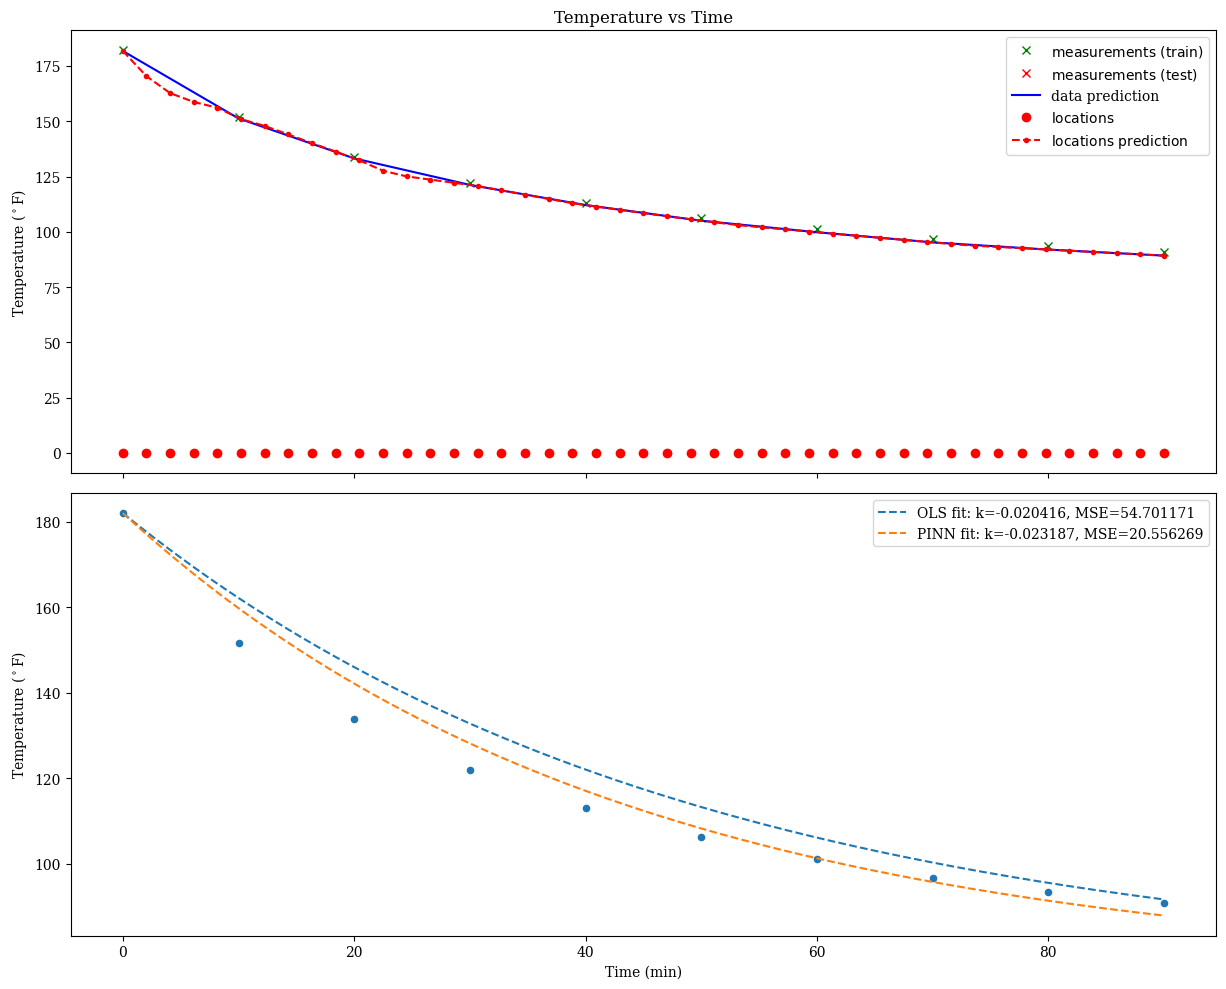

In [109]:
fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10), sharex=True)

model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

X.query(f"time <= {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query(f"time > {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"data prediction"
) 

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
) 

# ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Temperature ($^\circ$F)")
ax1.set_title("Temperature vs Time")
ax1.legend()


X.plot.scatter(x='time', y='temperature', ax=ax2)
t = np.linspace(0, 90, 1000)

T = (X['temperature'][0] - S) * np.exp(k * t) + S
_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(k * X['time']) + S)
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"OLS fit: k={k:.6f}, MSE={_mse:.6f}",
) 

_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(_k.item() * X['time']) + S)
T = (X['temperature'][0] - S) * np.exp(_k.item() * t) + S
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"PINN fit: k={_k.item():.6f}, MSE={_mse:.6f}",
) 

ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature ($^\circ$F)")
ax2.legend()

plt.tight_layout()

## tanh

In [110]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            # _architecture.append(nn.BatchNorm1d(layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;

_locations = torch.linspace(0, 90, 45).view(-1,1).requires_grad_(True).to(device)
_S = torch.tensor(S, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(1.0, dtype=torch.float, requires_grad=True, device=device)
_T0 = torch.tensor(X["temperature"][0], dtype=torch.float, requires_grad=False).to(device)

# model = MultiLayerPerceptronRegressor(architecture, nn.LeakyReLU)
model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
# model = MultiLayerPerceptronRegressor(architecture, nn.ReLU)
model.to(device)
optimizer = optim.Adam([
    {"params": model.parameters()}, 
    {"params": [_k]}
], lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], k=[])

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]

    _diff_equation = dydt - _k * (y_location_hat - _S)

    physics_loss = torch.mean(_diff_equation**2)
    _T0_loss = criterion(y_location_hat[0], _T0)

    loss = data_loss + (1e-2)*(physics_loss + _T0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, T0 Loss: {_T0_loss.item():.6f}, Total Loss: {loss.item():.6f}")
        print(f"k: {_k.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())
        plot_loss_train["k"].append(_k.item())

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|          | 0/50000 [00:00<?, ?it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1056/50000 [00:04<02:34, 316.92it/s]

Data Loss: 7858.509277, Physics Loss: 255.995728, T0 Loss: 21629.267578, Total Loss: 8077.361816
k: 0.403049


  4%|▍         | 2037/50000 [00:07<03:14, 247.15it/s]

Data Loss: 4057.087158, Physics Loss: 11.247972, T0 Loss: 14448.325195, Total Loss: 4201.683105
k: 0.261957


  6%|▌         | 3042/50000 [00:11<03:03, 256.29it/s]

Data Loss: 1980.172729, Physics Loss: 5.939316, T0 Loss: 9533.787109, Total Loss: 2075.570068
k: 0.249692


  8%|▊         | 4040/50000 [00:15<03:14, 236.27it/s]

Data Loss: 1066.102539, Physics Loss: 9.423271, T0 Loss: 6403.800781, Total Loss: 1130.234741
k: 0.111923


 10%|█         | 5035/50000 [00:18<02:59, 249.92it/s]

Data Loss: 804.285461, Physics Loss: 0.008167, T0 Loss: 4695.593262, Total Loss: 851.241455
k: 0.002310


 12%|█▏        | 6044/50000 [00:23<03:00, 243.68it/s]

Data Loss: 772.831299, Physics Loss: 0.000000, T0 Loss: 4023.414307, Total Loss: 813.065430
k: 0.000000


 14%|█▍        | 7040/50000 [00:27<02:50, 251.90it/s]

Data Loss: 772.843628, Physics Loss: 0.000000, T0 Loss: 3886.058350, Total Loss: 811.704224
k: 0.000000


 16%|█▌        | 8064/50000 [00:30<02:00, 348.85it/s]

Data Loss: 772.926208, Physics Loss: 0.000000, T0 Loss: 3877.301758, Total Loss: 811.699219
k: 0.000000


 18%|█▊        | 9037/50000 [00:33<02:13, 307.32it/s]

Data Loss: 772.926392, Physics Loss: 0.000000, T0 Loss: 3877.274170, Total Loss: 811.699158
k: 0.000000


 20%|██        | 10043/50000 [00:36<01:47, 370.08it/s]

Data Loss: 772.926453, Physics Loss: 0.000000, T0 Loss: 3877.253174, Total Loss: 811.698975
k: 0.000000


 22%|██▏       | 11033/50000 [00:38<01:32, 419.39it/s]

Data Loss: 772.926453, Physics Loss: 0.000000, T0 Loss: 3877.239990, Total Loss: 811.698853
k: 0.000000


 24%|██▍       | 12063/50000 [00:42<01:57, 322.16it/s]

Data Loss: 772.838806, Physics Loss: 0.000000, T0 Loss: 3876.840820, Total Loss: 811.607239
k: -0.000001


 26%|██▌       | 13059/50000 [00:45<01:48, 341.37it/s]

Data Loss: 772.708740, Physics Loss: 0.000000, T0 Loss: 3876.398193, Total Loss: 811.472717
k: -0.000003


 28%|██▊       | 14051/50000 [00:47<01:47, 335.39it/s]

Data Loss: 36.285446, Physics Loss: 0.317186, T0 Loss: 362.816589, Total Loss: 39.916782
k: -0.018090


 30%|███       | 15039/50000 [00:50<01:33, 374.40it/s]

Data Loss: 1.452144, Physics Loss: 0.852481, T0 Loss: 14.489119, Total Loss: 1.605560
k: -0.022763


 32%|███▏      | 16065/50000 [00:53<01:36, 352.19it/s]

Data Loss: 0.011330, Physics Loss: 0.755163, T0 Loss: 0.084779, Total Loss: 0.019729
k: -0.024025


 34%|███▍      | 17042/50000 [00:56<01:50, 298.22it/s]

Data Loss: 0.002709, Physics Loss: 0.714867, T0 Loss: 0.000049, Total Loss: 0.009859
k: -0.024436


 36%|███▌      | 18037/50000 [01:00<02:07, 251.09it/s]

Data Loss: 0.002592, Physics Loss: 0.644506, T0 Loss: 0.000011, Total Loss: 0.009037
k: -0.024533


 38%|███▊      | 19057/50000 [01:03<01:13, 422.75it/s]

Data Loss: 0.411132, Physics Loss: 0.429233, T0 Loss: 0.000070, Total Loss: 0.415425
k: -0.024845


 40%|████      | 20048/50000 [01:07<01:33, 319.25it/s]

Data Loss: 0.003077, Physics Loss: 0.279292, T0 Loss: 0.000034, Total Loss: 0.005870
k: -0.024713


 42%|████▏     | 21064/50000 [01:09<01:26, 333.18it/s]

Data Loss: 0.002940, Physics Loss: 0.083795, T0 Loss: 0.000004, Total Loss: 0.003778
k: -0.026207


 44%|████▍     | 22059/50000 [01:12<01:06, 420.61it/s]

Data Loss: 0.002877, Physics Loss: 0.060643, T0 Loss: 0.000002, Total Loss: 0.003484
k: -0.025472


 46%|████▌     | 23043/50000 [01:14<01:04, 415.00it/s]

Data Loss: 0.002803, Physics Loss: 0.044439, T0 Loss: 0.000000, Total Loss: 0.003247
k: -0.024717


 48%|████▊     | 24036/50000 [01:18<01:48, 238.77it/s]

Data Loss: 0.002808, Physics Loss: 0.034504, T0 Loss: 0.000000, Total Loss: 0.003153
k: -0.024099


 50%|█████     | 25025/50000 [01:22<01:41, 245.37it/s]

Data Loss: 0.003356, Physics Loss: 0.028218, T0 Loss: 0.000022, Total Loss: 0.003638
k: -0.023620


 52%|█████▏    | 26032/50000 [01:26<01:37, 244.62it/s]

Data Loss: 0.002825, Physics Loss: 0.023983, T0 Loss: 0.000000, Total Loss: 0.003065
k: -0.023320


 54%|█████▍    | 27043/50000 [01:30<01:36, 238.80it/s]

Data Loss: 0.002852, Physics Loss: 0.021920, T0 Loss: 0.000000, Total Loss: 0.003071
k: -0.023076


 56%|█████▌    | 28045/50000 [01:34<01:34, 233.19it/s]

Data Loss: 0.002875, Physics Loss: 0.020941, T0 Loss: 0.000000, Total Loss: 0.003085
k: -0.022932


 58%|█████▊    | 29025/50000 [01:38<01:26, 242.45it/s]

Data Loss: 0.002888, Physics Loss: 0.020357, T0 Loss: 0.000000, Total Loss: 0.003092
k: -0.022849


 60%|██████    | 30045/50000 [01:42<01:22, 242.67it/s]

Data Loss: 0.002899, Physics Loss: 0.019845, T0 Loss: 0.000000, Total Loss: 0.003097
k: -0.022792


 62%|██████▏   | 31059/50000 [01:45<00:46, 405.04it/s]

Data Loss: 0.002884, Physics Loss: 0.019473, T0 Loss: 0.000000, Total Loss: 0.003079
k: -0.022761


 64%|██████▍   | 32080/50000 [01:48<00:42, 419.33it/s]

Data Loss: 0.032301, Physics Loss: 0.019057, T0 Loss: 0.000037, Total Loss: 0.032492
k: -0.022722


 66%|██████▌   | 33038/50000 [01:51<00:55, 303.83it/s]

Data Loss: 0.061776, Physics Loss: 0.018645, T0 Loss: 0.000036, Total Loss: 0.061963
k: -0.022717


 68%|██████▊   | 34052/50000 [01:54<00:39, 406.54it/s]

Data Loss: 0.002762, Physics Loss: 0.018573, T0 Loss: 0.000000, Total Loss: 0.002947
k: -0.022660


 70%|███████   | 35048/50000 [01:56<00:44, 339.69it/s]

Data Loss: 0.002696, Physics Loss: 0.018328, T0 Loss: 0.000000, Total Loss: 0.002879
k: -0.022628


 72%|███████▏  | 36054/50000 [01:59<00:49, 281.65it/s]

Data Loss: 0.002626, Physics Loss: 0.018108, T0 Loss: 0.000000, Total Loss: 0.002807
k: -0.022596


 74%|███████▍  | 37072/50000 [02:02<00:31, 408.24it/s]

Data Loss: 0.020167, Physics Loss: 0.017912, T0 Loss: 0.000002, Total Loss: 0.020346
k: -0.022468


 76%|███████▌  | 38036/50000 [02:05<00:40, 297.35it/s]

Data Loss: 0.002482, Physics Loss: 0.017760, T0 Loss: 0.000000, Total Loss: 0.002660
k: -0.022524


 78%|███████▊  | 39049/50000 [02:09<00:32, 341.66it/s]

Data Loss: 0.002373, Physics Loss: 0.017617, T0 Loss: 0.000000, Total Loss: 0.002549
k: -0.022483


 80%|████████  | 40050/50000 [02:13<00:40, 246.48it/s]

Data Loss: 0.002245, Physics Loss: 0.017507, T0 Loss: 0.000000, Total Loss: 0.002420
k: -0.022444


 82%|████████▏ | 41024/50000 [02:17<00:37, 241.14it/s]

Data Loss: 0.053129, Physics Loss: 0.017865, T0 Loss: 0.000012, Total Loss: 0.053307
k: -0.022295


 84%|████████▍ | 42039/50000 [02:21<00:33, 239.76it/s]

Data Loss: 0.007335, Physics Loss: 0.017578, T0 Loss: 0.000000, Total Loss: 0.007511
k: -0.022248


 86%|████████▌ | 43025/50000 [02:25<00:28, 247.19it/s]

Data Loss: 0.001169, Physics Loss: 0.017586, T0 Loss: 0.000000, Total Loss: 0.001345
k: -0.022293


 88%|████████▊ | 44040/50000 [02:29<00:24, 243.24it/s]

Data Loss: 0.001426, Physics Loss: 0.017888, T0 Loss: 0.000001, Total Loss: 0.001605
k: -0.022288


 90%|█████████ | 45037/50000 [02:33<00:20, 240.04it/s]

Data Loss: 0.000153, Physics Loss: 0.017871, T0 Loss: 0.000000, Total Loss: 0.000332
k: -0.022292


 92%|█████████▏| 46026/50000 [02:38<00:16, 240.96it/s]

Data Loss: 0.001303, Physics Loss: 0.018028, T0 Loss: 0.000001, Total Loss: 0.001483
k: -0.022298


 94%|█████████▍| 47042/50000 [02:41<00:10, 289.82it/s]

Data Loss: 0.000000, Physics Loss: 0.017861, T0 Loss: 0.000000, Total Loss: 0.000179
k: -0.022369


 96%|█████████▌| 48041/50000 [02:45<00:08, 237.28it/s]

Data Loss: 0.006331, Physics Loss: 0.018203, T0 Loss: 0.000000, Total Loss: 0.006513
k: -0.022333


 98%|█████████▊| 49038/50000 [02:50<00:04, 239.95it/s]

Data Loss: 0.046351, Physics Loss: 0.017928, T0 Loss: 0.000037, Total Loss: 0.046531
k: -0.022428


100%|██████████| 50000/50000 [02:53<00:00, 288.26it/s]

Data Loss: 0.000000, Physics Loss: 0.017888, T0 Loss: 0.000000, Total Loss: 0.000179
k: -0.022393


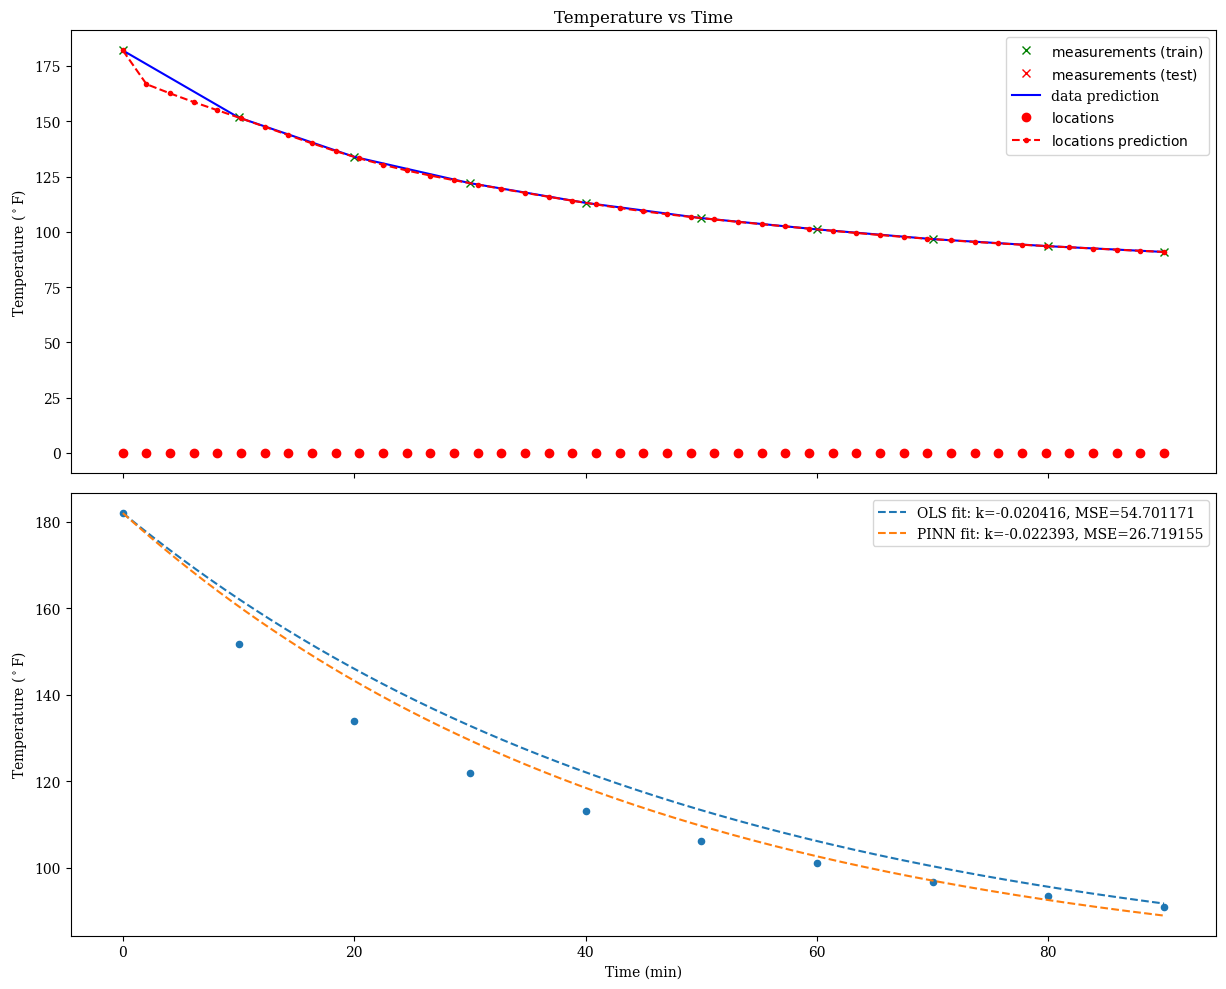

In [112]:
fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10), sharex=True)

model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

X.query(f"time <= {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query(f"time > {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"data prediction"
) 

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
) 

# ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Temperature ($^\circ$F)")
ax1.set_title("Temperature vs Time")
ax1.legend()


X.plot.scatter(x='time', y='temperature', ax=ax2)
t = np.linspace(0, 90, 1000)

T = (X['temperature'][0] - S) * np.exp(k * t) + S
_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(k * X['time']) + S)
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"OLS fit: k={k:.6f}, MSE={_mse:.6f}",
) 

_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(_k.item() * X['time']) + S)
T = (X['temperature'][0] - S) * np.exp(_k.item() * t) + S
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"PINN fit: k={_k.item():.6f}, MSE={_mse:.6f}",
) 

ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature ($^\circ$F)")
ax2.legend()

plt.tight_layout()

## gelu

In [113]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            # _architecture.append(nn.BatchNorm1d(layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;

_locations = torch.linspace(0, 90, 45).view(-1,1).requires_grad_(True).to(device)
_S = torch.tensor(S, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(1.0, dtype=torch.float, requires_grad=True, device=device)
_T0 = torch.tensor(X["temperature"][0], dtype=torch.float, requires_grad=False).to(device)

# model = MultiLayerPerceptronRegressor(architecture, nn.LeakyReLU)
# model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
# model = MultiLayerPerceptronRegressor(architecture, nn.ReLU)
model = MultiLayerPerceptronRegressor(architecture, nn.GELU)
model.to(device)
optimizer = optim.Adam([
    {"params": model.parameters()}, 
    {"params": [_k]}
], lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], k=[])

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]

    _diff_equation = dydt - _k * (y_location_hat - _S)

    physics_loss = torch.mean(_diff_equation**2)
    _T0_loss = criterion(y_location_hat[0], _T0)

    loss = data_loss + (1e-2)*(physics_loss + _T0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, T0 Loss: {_T0_loss.item():.6f}, Total Loss: {loss.item():.6f}")
        print(f"k: {_k.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())
        plot_loss_train["k"].append(_k.item())

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|          | 0/50000 [00:00<?, ?it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1040/50000 [00:03<02:52, 283.51it/s]

Data Loss: 0.020108, Physics Loss: 270.084137, T0 Loss: 0.006127, Total Loss: 2.721011
k: 0.344658


  4%|▍         | 2050/50000 [00:06<02:18, 347.07it/s]

Data Loss: 1.359980, Physics Loss: 6.569781, T0 Loss: 0.001178, Total Loss: 1.425689
k: 0.039876


  6%|▌         | 3053/50000 [00:09<01:54, 410.16it/s]

Data Loss: 0.001341, Physics Loss: 1.416979, T0 Loss: 0.000004, Total Loss: 0.015511
k: -0.008482


  8%|▊         | 4026/50000 [00:12<03:02, 251.35it/s]

Data Loss: 0.001017, Physics Loss: 1.433769, T0 Loss: 0.000000, Total Loss: 0.015355
k: -0.010660


 10%|█         | 5067/50000 [00:15<01:50, 406.40it/s]

Data Loss: 0.003205, Physics Loss: 1.471211, T0 Loss: 0.000006, Total Loss: 0.017917
k: -0.010797


 12%|█▏        | 6054/50000 [00:17<01:52, 389.43it/s]

Data Loss: 0.004201, Physics Loss: 1.491802, T0 Loss: 0.000025, Total Loss: 0.019120
k: -0.010724


 14%|█▍        | 7041/50000 [00:20<01:56, 367.96it/s]

Data Loss: 0.001064, Physics Loss: 1.459815, T0 Loss: 0.000004, Total Loss: 0.015663
k: -0.011241


 16%|█▌        | 8062/50000 [00:23<01:55, 362.60it/s]

Data Loss: 0.000676, Physics Loss: 1.471969, T0 Loss: 0.000000, Total Loss: 0.015395
k: -0.011342


 18%|█▊        | 9052/50000 [00:26<02:11, 310.81it/s]

Data Loss: 0.000335, Physics Loss: 1.468296, T0 Loss: 0.000000, Total Loss: 0.015018
k: -0.011376


 20%|██        | 10062/50000 [00:28<01:34, 421.66it/s]

Data Loss: 0.000223, Physics Loss: 1.458091, T0 Loss: 0.000000, Total Loss: 0.014804
k: -0.011511


 22%|██▏       | 11043/50000 [00:31<01:36, 404.25it/s]

Data Loss: 0.000255, Physics Loss: 1.440193, T0 Loss: 0.000000, Total Loss: 0.014657
k: -0.011730


 24%|██▍       | 12079/50000 [00:34<01:31, 415.42it/s]

Data Loss: 0.000238, Physics Loss: 1.406919, T0 Loss: 0.000000, Total Loss: 0.014308
k: -0.012008


 26%|██▌       | 13035/50000 [00:37<02:42, 227.15it/s]

Data Loss: 0.000481, Physics Loss: 1.403807, T0 Loss: 0.000009, Total Loss: 0.014519
k: -0.012178


 28%|██▊       | 14040/50000 [00:42<02:35, 231.42it/s]

Data Loss: 0.000417, Physics Loss: 1.375963, T0 Loss: 0.000000, Total Loss: 0.014176
k: -0.012413


 30%|███       | 15047/50000 [00:46<02:23, 244.05it/s]

Data Loss: 0.005613, Physics Loss: 1.368898, T0 Loss: 0.000162, Total Loss: 0.019304
k: -0.012525


 32%|███▏      | 16053/50000 [00:50<01:57, 287.95it/s]

Data Loss: 0.002997, Physics Loss: 1.347813, T0 Loss: 0.000049, Total Loss: 0.016476
k: -0.012690


 34%|███▍      | 17045/50000 [00:53<01:41, 323.56it/s]

Data Loss: 0.000708, Physics Loss: 1.328320, T0 Loss: 0.000000, Total Loss: 0.013991
k: -0.012876


 36%|███▌      | 18047/50000 [00:56<01:18, 406.58it/s]

Data Loss: 0.000813, Physics Loss: 1.309881, T0 Loss: 0.000000, Total Loss: 0.013912
k: -0.013013


 38%|███▊      | 19041/50000 [00:59<01:32, 333.33it/s]

Data Loss: 0.001214, Physics Loss: 1.301820, T0 Loss: 0.000006, Total Loss: 0.014232
k: -0.013100


 40%|████      | 20052/50000 [01:02<01:36, 310.47it/s]

Data Loss: 0.001066, Physics Loss: 1.279969, T0 Loss: 0.000001, Total Loss: 0.013866
k: -0.013240


 42%|████▏     | 21052/50000 [01:05<01:17, 372.10it/s]

Data Loss: 0.049577, Physics Loss: 1.293774, T0 Loss: 0.000011, Total Loss: 0.062515
k: -0.013320


 44%|████▍     | 22052/50000 [01:08<01:18, 357.06it/s]

Data Loss: 0.049867, Physics Loss: 1.249096, T0 Loss: 0.001214, Total Loss: 0.062371
k: -0.013533


 46%|████▌     | 23045/50000 [01:12<01:56, 230.87it/s]

Data Loss: 0.001935, Physics Loss: 1.215747, T0 Loss: 0.000011, Total Loss: 0.014092
k: -0.013712


 48%|████▊     | 24038/50000 [01:16<01:44, 248.73it/s]

Data Loss: 0.002803, Physics Loss: 1.198274, T0 Loss: 0.000030, Total Loss: 0.014786
k: -0.013760


 50%|█████     | 25065/50000 [01:19<01:05, 381.49it/s]

Data Loss: 0.001728, Physics Loss: 1.164966, T0 Loss: 0.000001, Total Loss: 0.013377
k: -0.013901


 52%|█████▏    | 26070/50000 [01:22<01:01, 388.15it/s]

Data Loss: 0.001858, Physics Loss: 1.148510, T0 Loss: 0.000000, Total Loss: 0.013344
k: -0.013977


 54%|█████▍    | 27046/50000 [01:26<01:41, 227.15it/s]

Data Loss: 0.002293, Physics Loss: 1.120087, T0 Loss: 0.000003, Total Loss: 0.013494
k: -0.014096


 56%|█████▌    | 28042/50000 [01:30<01:32, 236.24it/s]

Data Loss: 0.002000, Physics Loss: 1.083001, T0 Loss: 0.000000, Total Loss: 0.012830
k: -0.014237


 58%|█████▊    | 29033/50000 [01:34<01:35, 220.68it/s]

Data Loss: 0.002129, Physics Loss: 1.059242, T0 Loss: 0.000000, Total Loss: 0.012722
k: -0.014334


 60%|██████    | 30052/50000 [01:38<01:07, 294.55it/s]

Data Loss: 0.002201, Physics Loss: 1.033615, T0 Loss: 0.000000, Total Loss: 0.012537
k: -0.014442


 62%|██████▏   | 31080/50000 [01:41<00:47, 401.23it/s]

Data Loss: 0.002241, Physics Loss: 0.989555, T0 Loss: 0.000000, Total Loss: 0.012136
k: -0.014612


 64%|██████▍   | 32061/50000 [01:44<00:55, 320.62it/s]

Data Loss: 0.015825, Physics Loss: 0.988662, T0 Loss: 0.000000, Total Loss: 0.025712
k: -0.014658


 66%|██████▌   | 33047/50000 [01:46<00:52, 324.23it/s]

Data Loss: 0.002782, Physics Loss: 0.960487, T0 Loss: 0.000005, Total Loss: 0.012387
k: -0.014744


 68%|██████▊   | 34039/50000 [01:50<00:51, 308.86it/s]

Data Loss: 0.003058, Physics Loss: 0.932831, T0 Loss: 0.000040, Total Loss: 0.012387
k: -0.014808


 70%|███████   | 35072/50000 [01:52<00:35, 415.85it/s]

Data Loss: 0.002638, Physics Loss: 0.899515, T0 Loss: 0.000000, Total Loss: 0.011633
k: -0.014970


 72%|███████▏  | 36047/50000 [01:55<00:34, 402.83it/s]

Data Loss: 1.455121, Physics Loss: 0.849066, T0 Loss: 0.007180, Total Loss: 1.463684
k: -0.014677


 74%|███████▍  | 37056/50000 [01:57<00:31, 417.09it/s]

Data Loss: 0.144168, Physics Loss: 0.866129, T0 Loss: 0.000020, Total Loss: 0.152830
k: -0.015349


 76%|███████▌  | 38070/50000 [02:00<00:28, 414.48it/s]

Data Loss: 0.294225, Physics Loss: 0.817670, T0 Loss: 0.016973, Total Loss: 0.302571
k: -0.015090


 78%|███████▊  | 39062/50000 [02:02<00:28, 379.53it/s]

Data Loss: 0.002803, Physics Loss: 0.786182, T0 Loss: 0.000001, Total Loss: 0.010665
k: -0.015429


 80%|████████  | 40052/50000 [02:05<00:27, 359.18it/s]

Data Loss: 0.002798, Physics Loss: 0.755137, T0 Loss: 0.000000, Total Loss: 0.010349
k: -0.015556


 82%|████████▏ | 41045/50000 [02:09<00:29, 304.16it/s]

Data Loss: 0.015506, Physics Loss: 0.737493, T0 Loss: 0.001747, Total Loss: 0.022899
k: -0.015580


 84%|████████▍ | 42054/50000 [02:11<00:21, 374.91it/s]

Data Loss: 18.533609, Physics Loss: 0.704780, T0 Loss: 0.018100, Total Loss: 18.540838
k: -0.015792


 86%|████████▌ | 43027/50000 [02:14<00:28, 247.13it/s]

Data Loss: 0.002922, Physics Loss: 0.663815, T0 Loss: 0.000002, Total Loss: 0.009560
k: -0.015912


 88%|████████▊ | 44036/50000 [02:19<00:26, 225.43it/s]

Data Loss: 0.003100, Physics Loss: 0.634243, T0 Loss: 0.000004, Total Loss: 0.009443
k: -0.016023


 90%|█████████ | 45036/50000 [02:23<00:16, 304.67it/s]

Data Loss: 0.005198, Physics Loss: 0.618962, T0 Loss: 0.000027, Total Loss: 0.011388
k: -0.016031


 92%|█████████▏| 46047/50000 [02:25<00:09, 397.91it/s]

Data Loss: 0.006492, Physics Loss: 0.590579, T0 Loss: 0.000537, Total Loss: 0.012403
k: -0.016211


 94%|█████████▍| 47060/50000 [02:28<00:07, 387.89it/s]

Data Loss: 0.004468, Physics Loss: 0.574799, T0 Loss: 0.000424, Total Loss: 0.010220
k: -0.016188


 96%|█████████▌| 48072/50000 [02:31<00:05, 356.16it/s]

Data Loss: 0.004008, Physics Loss: 0.552403, T0 Loss: 0.000022, Total Loss: 0.009532
k: -0.016392


 98%|█████████▊| 49028/50000 [02:34<00:03, 260.07it/s]

Data Loss: 0.002973, Physics Loss: 0.536381, T0 Loss: 0.000001, Total Loss: 0.008336
k: -0.016412


100%|██████████| 50000/50000 [02:37<00:00, 317.18it/s]

Data Loss: 0.016826, Physics Loss: 0.556348, T0 Loss: 0.000559, Total Loss: 0.022395
k: -0.016250


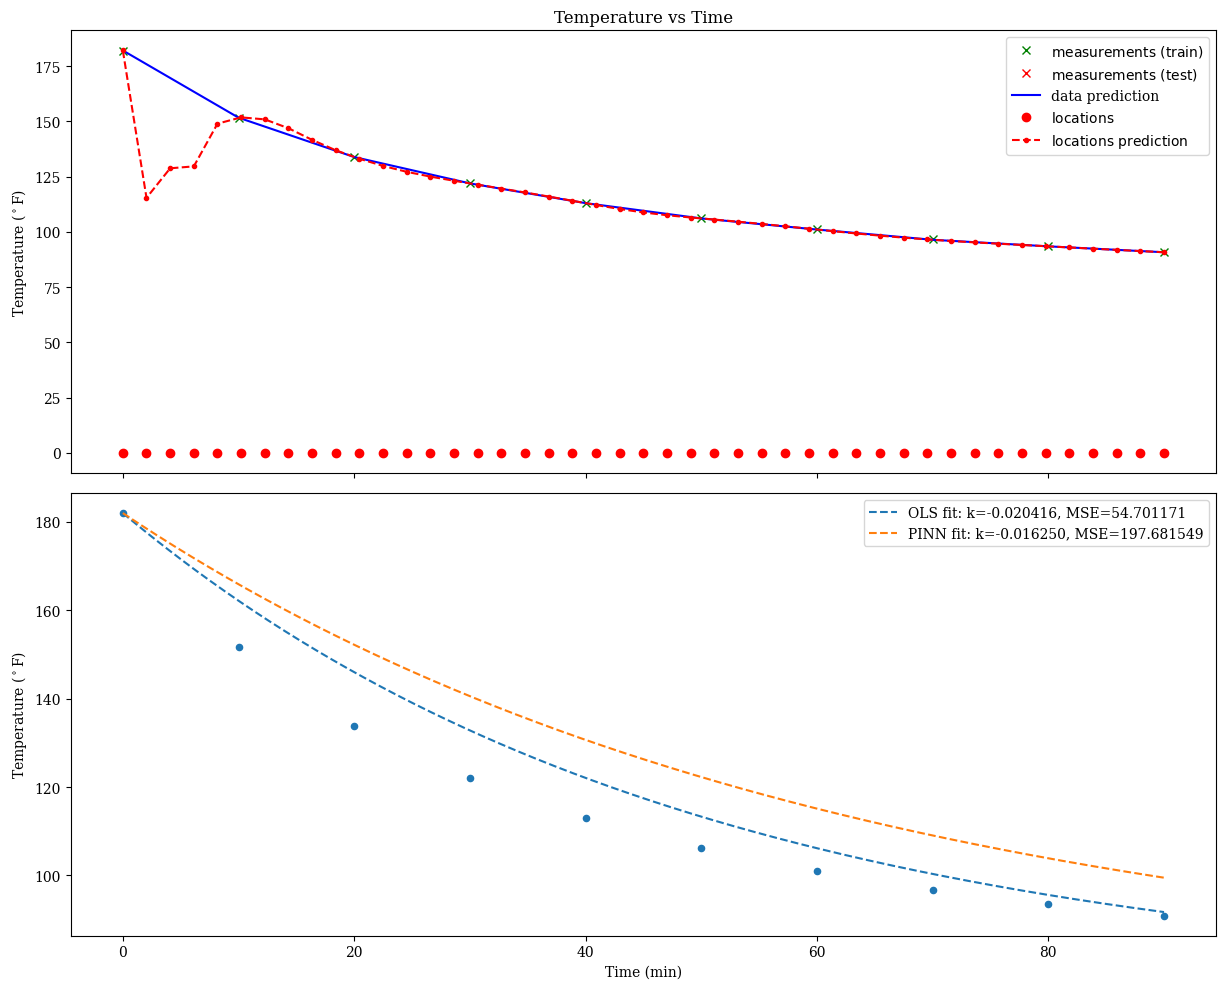

In [114]:
fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10), sharex=True)

model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

X.query(f"time <= {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query(f"time > {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"data prediction"
) 

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
) 

# ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Temperature ($^\circ$F)")
ax1.set_title("Temperature vs Time")
ax1.legend()


X.plot.scatter(x='time', y='temperature', ax=ax2)
t = np.linspace(0, 90, 1000)

T = (X['temperature'][0] - S) * np.exp(k * t) + S
_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(k * X['time']) + S)
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"OLS fit: k={k:.6f}, MSE={_mse:.6f}",
) 

_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(_k.item() * X['time']) + S)
T = (X['temperature'][0] - S) * np.exp(_k.item() * t) + S
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"PINN fit: k={_k.item():.6f}, MSE={_mse:.6f}",
) 

ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature ($^\circ$F)")
ax2.legend()

plt.tight_layout()

## elu

In [115]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            # _architecture.append(nn.BatchNorm1d(layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;

_locations = torch.linspace(0, 90, 45).view(-1,1).requires_grad_(True).to(device)
_S = torch.tensor(S, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(1.0, dtype=torch.float, requires_grad=True, device=device)
_T0 = torch.tensor(X["temperature"][0], dtype=torch.float, requires_grad=False).to(device)

# model = MultiLayerPerceptronRegressor(architecture, nn.LeakyReLU)
# model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
# model = MultiLayerPerceptronRegressor(architecture, nn.ReLU)
# model = MultiLayerPerceptronRegressor(architecture, nn.GELU)
model = MultiLayerPerceptronRegressor(architecture, nn.ELU)
model.to(device)
optimizer = optim.Adam([
    {"params": model.parameters()}, 
    {"params": [_k]}
], lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], k=[])

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]

    _diff_equation = dydt - _k * (y_location_hat - _S)

    physics_loss = torch.mean(_diff_equation**2)
    _T0_loss = criterion(y_location_hat[0], _T0)

    loss = data_loss + (1e-2)*(physics_loss + _T0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, T0 Loss: {_T0_loss.item():.6f}, Total Loss: {loss.item():.6f}")
        print(f"k: {_k.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())
        plot_loss_train["k"].append(_k.item())

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|          | 0/50000 [00:00<?, ?it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1047/50000 [00:03<02:48, 289.89it/s]

Data Loss: 0.015310, Physics Loss: 242.697647, T0 Loss: 0.002704, Total Loss: 2.442314
k: 0.290189


  4%|▍         | 2046/50000 [00:06<02:30, 318.61it/s]

Data Loss: 0.002063, Physics Loss: 3.649755, T0 Loss: 0.000002, Total Loss: 0.038560
k: 0.010085


  6%|▌         | 3032/50000 [00:09<02:26, 320.12it/s]

Data Loss: 0.000457, Physics Loss: 0.537613, T0 Loss: 0.000006, Total Loss: 0.005833
k: -0.021961


  8%|▊         | 4050/50000 [00:12<01:59, 384.30it/s]

Data Loss: 0.044423, Physics Loss: 0.244210, T0 Loss: 0.000095, Total Loss: 0.046866
k: -0.023753


 10%|█         | 5036/50000 [00:15<01:52, 399.50it/s]

Data Loss: 0.000275, Physics Loss: 0.122209, T0 Loss: 0.000001, Total Loss: 0.001497
k: -0.024596


 12%|█▏        | 6068/50000 [00:17<02:00, 364.90it/s]

Data Loss: 0.000333, Physics Loss: 0.070976, T0 Loss: 0.000000, Total Loss: 0.001042
k: -0.024998


 14%|█▍        | 7074/50000 [00:20<01:42, 420.54it/s]

Data Loss: 0.000255, Physics Loss: 0.057323, T0 Loss: 0.000001, Total Loss: 0.000828
k: -0.025175


 16%|█▌        | 8042/50000 [00:23<01:40, 418.11it/s]

Data Loss: 0.000760, Physics Loss: 0.051611, T0 Loss: 0.000026, Total Loss: 0.001276
k: -0.025236


 18%|█▊        | 9058/50000 [00:26<01:54, 359.01it/s]

Data Loss: 0.008776, Physics Loss: 0.048903, T0 Loss: 0.000273, Total Loss: 0.009268
k: -0.025275


 20%|██        | 10042/50000 [00:29<02:24, 276.80it/s]

Data Loss: 0.000044, Physics Loss: 0.048154, T0 Loss: 0.000000, Total Loss: 0.000526
k: -0.025305


 22%|██▏       | 11028/50000 [00:33<02:40, 242.35it/s]

Data Loss: 0.000224, Physics Loss: 0.047542, T0 Loss: 0.000013, Total Loss: 0.000700
k: -0.025344


 24%|██▍       | 12033/50000 [00:37<02:25, 261.46it/s]

Data Loss: 0.000092, Physics Loss: 0.046305, T0 Loss: 0.000000, Total Loss: 0.000555
k: -0.025294


 26%|██▌       | 13031/50000 [00:41<02:34, 240.03it/s]

Data Loss: 0.000108, Physics Loss: 0.045545, T0 Loss: 0.000003, Total Loss: 0.000563
k: -0.025271


 28%|██▊       | 14036/50000 [00:45<02:37, 227.69it/s]

Data Loss: 0.000050, Physics Loss: 0.044940, T0 Loss: 0.000000, Total Loss: 0.000499
k: -0.025248


 30%|███       | 15044/50000 [00:49<02:33, 227.37it/s]

Data Loss: 0.000118, Physics Loss: 0.044847, T0 Loss: 0.000000, Total Loss: 0.000566
k: -0.025255


 32%|███▏      | 16042/50000 [00:54<02:26, 231.23it/s]

Data Loss: 0.001083, Physics Loss: 0.044479, T0 Loss: 0.000101, Total Loss: 0.001528
k: -0.025203


 34%|███▍      | 17027/50000 [00:58<02:23, 229.19it/s]

Data Loss: 0.000088, Physics Loss: 0.044913, T0 Loss: 0.000000, Total Loss: 0.000537
k: -0.025191


 36%|███▌      | 18043/50000 [01:02<01:47, 297.15it/s]

Data Loss: 0.020310, Physics Loss: 0.045167, T0 Loss: 0.003424, Total Loss: 0.020796
k: -0.025135


 38%|███▊      | 19043/50000 [01:06<02:13, 231.48it/s]

Data Loss: 0.000219, Physics Loss: 0.044575, T0 Loss: 0.000000, Total Loss: 0.000665
k: -0.025151


 40%|████      | 20039/50000 [01:10<01:58, 253.29it/s]

Data Loss: 0.011005, Physics Loss: 0.044269, T0 Loss: 0.002063, Total Loss: 0.011469
k: -0.025125


 42%|████▏     | 21030/50000 [01:14<02:06, 228.90it/s]

Data Loss: 0.000443, Physics Loss: 0.044144, T0 Loss: 0.000095, Total Loss: 0.000886
k: -0.025136


 44%|████▍     | 22032/50000 [01:18<01:47, 260.80it/s]

Data Loss: 0.000060, Physics Loss: 0.044124, T0 Loss: 0.000000, Total Loss: 0.000501
k: -0.025122


 46%|████▌     | 23040/50000 [01:22<01:56, 231.75it/s]

Data Loss: 0.000059, Physics Loss: 0.043696, T0 Loss: 0.000004, Total Loss: 0.000496
k: -0.025103


 48%|████▊     | 24041/50000 [01:26<01:52, 231.50it/s]

Data Loss: 0.000059, Physics Loss: 0.043463, T0 Loss: 0.000001, Total Loss: 0.000493
k: -0.025086


 50%|█████     | 25055/50000 [01:30<01:17, 320.07it/s]

Data Loss: 0.000131, Physics Loss: 0.043168, T0 Loss: 0.000022, Total Loss: 0.000563
k: -0.025065


 52%|█████▏    | 26072/50000 [01:33<01:07, 356.50it/s]

Data Loss: 0.022383, Physics Loss: 0.043170, T0 Loss: 0.005595, Total Loss: 0.022871
k: -0.024999


 54%|█████▍    | 27018/50000 [01:36<01:18, 292.53it/s]

Data Loss: 0.000030, Physics Loss: 0.042674, T0 Loss: 0.000004, Total Loss: 0.000456
k: -0.025032


 56%|█████▌    | 28058/50000 [01:39<00:56, 385.05it/s]

Data Loss: 0.000024, Physics Loss: 0.042170, T0 Loss: 0.000000, Total Loss: 0.000446
k: -0.025012


 58%|█████▊    | 29044/50000 [01:42<01:12, 290.29it/s]

Data Loss: 0.000029, Physics Loss: 0.041658, T0 Loss: 0.000000, Total Loss: 0.000446
k: -0.024981


 60%|██████    | 30050/50000 [01:45<00:55, 356.85it/s]

Data Loss: 0.000029, Physics Loss: 0.041118, T0 Loss: 0.000000, Total Loss: 0.000440
k: -0.024949


 62%|██████▏   | 31051/50000 [01:47<00:48, 394.55it/s]

Data Loss: 0.000064, Physics Loss: 0.040610, T0 Loss: 0.000012, Total Loss: 0.000470
k: -0.024912


 64%|██████▍   | 32059/50000 [01:50<00:50, 357.77it/s]

Data Loss: 0.001800, Physics Loss: 0.039820, T0 Loss: 0.000458, Total Loss: 0.002203
k: -0.024861


 66%|██████▌   | 33081/50000 [01:53<00:41, 406.18it/s]

Data Loss: 0.000066, Physics Loss: 0.038880, T0 Loss: 0.000000, Total Loss: 0.000454
k: -0.024825


 68%|██████▊   | 34043/50000 [01:56<00:52, 301.38it/s]

Data Loss: 0.000072, Physics Loss: 0.037912, T0 Loss: 0.000000, Total Loss: 0.000451
k: -0.024769


 70%|███████   | 35035/50000 [02:00<00:58, 255.61it/s]

Data Loss: 0.014728, Physics Loss: 0.037124, T0 Loss: 0.006832, Total Loss: 0.015168
k: -0.024674


 72%|███████▏  | 36038/50000 [02:04<01:00, 230.64it/s]

Data Loss: 0.000109, Physics Loss: 0.036115, T0 Loss: 0.000001, Total Loss: 0.000470
k: -0.024649


 74%|███████▍  | 37065/50000 [02:08<00:39, 325.68it/s]

Data Loss: 0.000139, Physics Loss: 0.035047, T0 Loss: 0.000005, Total Loss: 0.000489
k: -0.024581


 76%|███████▌  | 38038/50000 [02:12<00:45, 262.47it/s]

Data Loss: 0.000111, Physics Loss: 0.033817, T0 Loss: 0.000000, Total Loss: 0.000449
k: -0.024503


 78%|███████▊  | 39071/50000 [02:15<00:28, 381.39it/s]

Data Loss: 0.000099, Physics Loss: 0.032604, T0 Loss: 0.000000, Total Loss: 0.000425
k: -0.024417


 80%|████████  | 40035/50000 [02:18<00:29, 335.01it/s]

Data Loss: 0.000094, Physics Loss: 0.031303, T0 Loss: 0.000002, Total Loss: 0.000407
k: -0.024322


 82%|████████▏ | 41049/50000 [02:21<00:31, 280.08it/s]

Data Loss: 0.000087, Physics Loss: 0.030080, T0 Loss: 0.000000, Total Loss: 0.000387
k: -0.024228


 84%|████████▍ | 42029/50000 [02:25<00:34, 229.11it/s]

Data Loss: 0.004942, Physics Loss: 0.029076, T0 Loss: 0.000854, Total Loss: 0.005242
k: -0.024079


 86%|████████▌ | 43075/50000 [02:29<00:22, 307.04it/s]

Data Loss: 0.000087, Physics Loss: 0.027749, T0 Loss: 0.000000, Total Loss: 0.000365
k: -0.024043


 88%|████████▊ | 44034/50000 [02:32<00:27, 220.69it/s]

Data Loss: 0.000076, Physics Loss: 0.026650, T0 Loss: 0.000000, Total Loss: 0.000342
k: -0.023950


 90%|█████████ | 45034/50000 [02:36<00:19, 248.57it/s]

Data Loss: 0.000017, Physics Loss: 0.025753, T0 Loss: 0.000003, Total Loss: 0.000275
k: -0.023860


 92%|█████████▏| 46034/50000 [02:40<00:11, 343.83it/s]

Data Loss: 0.000007, Physics Loss: 0.024605, T0 Loss: 0.000000, Total Loss: 0.000254
k: -0.023758


 94%|█████████▍| 47080/50000 [02:43<00:07, 394.26it/s]

Data Loss: 0.000022, Physics Loss: 0.023513, T0 Loss: 0.000001, Total Loss: 0.000257
k: -0.023661


 96%|█████████▌| 48050/50000 [02:45<00:05, 375.07it/s]

Data Loss: 0.000092, Physics Loss: 0.022582, T0 Loss: 0.000025, Total Loss: 0.000319
k: -0.023555


 98%|█████████▊| 49041/50000 [02:48<00:02, 353.15it/s]

Data Loss: 0.034063, Physics Loss: 0.021939, T0 Loss: 0.034360, Total Loss: 0.034626
k: -0.023507


100%|██████████| 50000/50000 [02:52<00:00, 290.10it/s]

Data Loss: 0.000243, Physics Loss: 0.021076, T0 Loss: 0.000025, Total Loss: 0.000454
k: -0.023369


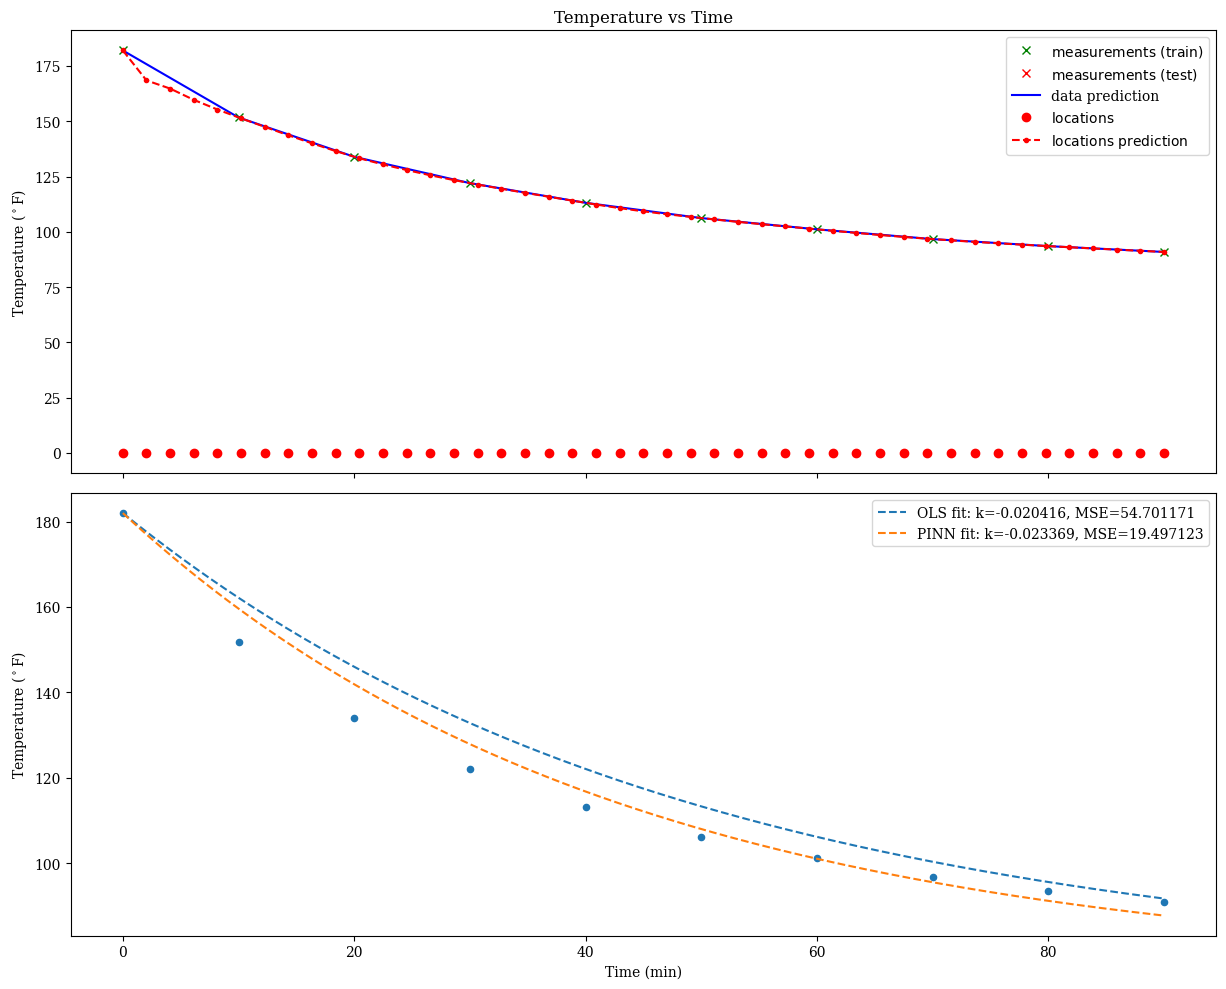

In [116]:
fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10), sharex=True)

model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

X.query(f"time <= {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query(f"time > {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"data prediction"
) 

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
) 

# ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Temperature ($^\circ$F)")
ax1.set_title("Temperature vs Time")
ax1.legend()


X.plot.scatter(x='time', y='temperature', ax=ax2)
t = np.linspace(0, 90, 1000)

T = (X['temperature'][0] - S) * np.exp(k * t) + S
_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(k * X['time']) + S)
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"OLS fit: k={k:.6f}, MSE={_mse:.6f}",
) 

_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(_k.item() * X['time']) + S)
T = (X['temperature'][0] - S) * np.exp(_k.item() * t) + S
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"PINN fit: k={_k.item():.6f}, MSE={_mse:.6f}",
) 

ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature ($^\circ$F)")
ax2.legend()

plt.tight_layout()

## swish

In [117]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            # _architecture.append(nn.BatchNorm1d(layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;

_locations = torch.linspace(0, 90, 45).view(-1,1).requires_grad_(True).to(device)
_S = torch.tensor(S, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(1.0, dtype=torch.float, requires_grad=True, device=device)
_T0 = torch.tensor(X["temperature"][0], dtype=torch.float, requires_grad=False).to(device)

# model = MultiLayerPerceptronRegressor(architecture, nn.LeakyReLU)
# model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
# model = MultiLayerPerceptronRegressor(architecture, nn.ReLU)
# model = MultiLayerPerceptronRegressor(architecture, nn.GELU)
model = MultiLayerPerceptronRegressor(architecture, Swish)
model.to(device)
optimizer = optim.Adam([
    {"params": model.parameters()}, 
    {"params": [_k]}
], lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], k=[])

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]

    _diff_equation = dydt - _k * (y_location_hat - _S)

    physics_loss = torch.mean(_diff_equation**2)
    _T0_loss = criterion(y_location_hat[0], _T0)

    loss = data_loss + (1e-2)*(physics_loss + _T0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, T0 Loss: {_T0_loss.item():.6f}, Total Loss: {loss.item():.6f}")
        print(f"k: {_k.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())
        plot_loss_train["k"].append(_k.item())

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Swish()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Swish()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Swish()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Swish()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|          | 0/50000 [00:00<?, ?it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1039/50000 [00:05<03:22, 241.43it/s]

Data Loss: 0.133373, Physics Loss: 315.484131, T0 Loss: 0.008564, Total Loss: 3.288300
k: 0.332176


  4%|▍         | 2023/50000 [00:10<04:07, 193.50it/s]

Data Loss: 0.028987, Physics Loss: 17.576664, T0 Loss: 0.001310, Total Loss: 0.204766
k: 0.014665


  6%|▌         | 3049/50000 [00:14<03:10, 246.92it/s]

Data Loss: 0.019785, Physics Loss: 4.705091, T0 Loss: 0.000124, Total Loss: 0.066837
k: -0.017041


  8%|▊         | 4026/50000 [00:19<03:55, 195.38it/s]

Data Loss: 0.012904, Physics Loss: 2.510888, T0 Loss: 0.000000, Total Loss: 0.038013
k: -0.009223


 10%|█         | 5025/50000 [00:24<03:55, 190.88it/s]

Data Loss: 0.189870, Physics Loss: 1.305393, T0 Loss: 0.001328, Total Loss: 0.202938
k: -0.010600


 12%|█▏        | 6042/50000 [00:28<02:12, 331.17it/s]

Data Loss: 0.058014, Physics Loss: 0.780495, T0 Loss: 0.000936, Total Loss: 0.065828
k: -0.012562


 14%|█▍        | 7034/50000 [00:33<03:20, 214.25it/s]

Data Loss: 0.060915, Physics Loss: 1.666885, T0 Loss: 0.000047, Total Loss: 0.077584
k: -0.008009


 16%|█▌        | 8028/50000 [00:38<03:30, 199.80it/s]

Data Loss: 0.004552, Physics Loss: 0.478783, T0 Loss: 0.000028, Total Loss: 0.009340
k: -0.015009


 18%|█▊        | 9040/50000 [00:42<02:39, 256.62it/s]

Data Loss: 0.003098, Physics Loss: 0.358361, T0 Loss: 0.000009, Total Loss: 0.006681
k: -0.016522


 20%|██        | 10023/50000 [00:47<03:29, 190.94it/s]

Data Loss: 0.002883, Physics Loss: 0.264958, T0 Loss: 0.000004, Total Loss: 0.005532
k: -0.017481


 22%|██▏       | 11047/50000 [00:52<02:05, 311.57it/s]

Data Loss: 0.003708, Physics Loss: 0.195952, T0 Loss: 0.000002, Total Loss: 0.005667
k: -0.018328


 24%|██▍       | 12021/50000 [00:56<03:16, 193.59it/s]

Data Loss: 0.004235, Physics Loss: 0.118043, T0 Loss: 0.000000, Total Loss: 0.005416
k: -0.019936


 26%|██▌       | 13038/50000 [01:01<03:11, 193.37it/s]

Data Loss: 0.006030, Physics Loss: 0.095577, T0 Loss: 0.000087, Total Loss: 0.006986
k: -0.020755


 28%|██▊       | 14047/50000 [01:05<01:46, 338.32it/s]

Data Loss: 0.003968, Physics Loss: 0.072179, T0 Loss: 0.000001, Total Loss: 0.004689
k: -0.021240


 30%|███       | 15050/50000 [01:08<01:38, 356.38it/s]

Data Loss: 0.003552, Physics Loss: 0.057292, T0 Loss: 0.000000, Total Loss: 0.004125
k: -0.021586


 32%|███▏      | 16053/50000 [01:11<02:00, 282.50it/s]

Data Loss: 0.003622, Physics Loss: 0.047674, T0 Loss: 0.000000, Total Loss: 0.004099
k: -0.021827


 34%|███▍      | 17063/50000 [01:14<01:37, 337.29it/s]

Data Loss: 0.003012, Physics Loss: 0.039558, T0 Loss: 0.000000, Total Loss: 0.003408
k: -0.021951


 36%|███▌      | 18066/50000 [01:17<01:30, 353.04it/s]

Data Loss: 0.003755, Physics Loss: 0.033741, T0 Loss: 0.000016, Total Loss: 0.004093
k: -0.022049


 38%|███▊      | 19034/50000 [01:21<02:04, 248.70it/s]

Data Loss: 0.047768, Physics Loss: 0.031102, T0 Loss: 0.002300, Total Loss: 0.048102
k: -0.021918


 40%|████      | 20035/50000 [01:26<02:20, 213.10it/s]

Data Loss: 0.002814, Physics Loss: 0.029989, T0 Loss: 0.000000, Total Loss: 0.003113
k: -0.021976


 42%|████▏     | 21021/50000 [01:30<02:23, 201.47it/s]

Data Loss: 0.003237, Physics Loss: 0.029012, T0 Loss: 0.000004, Total Loss: 0.003527
k: -0.021881


 44%|████▍     | 22027/50000 [01:35<02:25, 191.92it/s]

Data Loss: 0.003735, Physics Loss: 0.029653, T0 Loss: 0.000000, Total Loss: 0.004031
k: -0.021734


 46%|████▌     | 23068/50000 [01:39<01:16, 351.58it/s]

Data Loss: 0.966818, Physics Loss: 0.027845, T0 Loss: 0.078656, Total Loss: 0.967883
k: -0.021757


 48%|████▊     | 24065/50000 [01:42<01:17, 335.04it/s]

Data Loss: 0.002985, Physics Loss: 0.029903, T0 Loss: 0.000000, Total Loss: 0.003284
k: -0.021555


 50%|█████     | 25061/50000 [01:45<01:16, 325.91it/s]

Data Loss: 0.002996, Physics Loss: 0.030252, T0 Loss: 0.000000, Total Loss: 0.003299
k: -0.021514


 52%|█████▏    | 26034/50000 [01:49<02:04, 193.19it/s]

Data Loss: 0.002985, Physics Loss: 0.030602, T0 Loss: 0.000001, Total Loss: 0.003291
k: -0.021487


 54%|█████▍    | 27021/50000 [01:54<01:58, 193.71it/s]

Data Loss: 0.002952, Physics Loss: 0.030454, T0 Loss: 0.000000, Total Loss: 0.003257
k: -0.021479


 56%|█████▌    | 28023/50000 [01:58<01:51, 197.50it/s]

Data Loss: 0.003739, Physics Loss: 0.030425, T0 Loss: 0.000026, Total Loss: 0.004044
k: -0.021451


 58%|█████▊    | 29024/50000 [02:03<01:46, 196.10it/s]

Data Loss: 0.077841, Physics Loss: 0.029687, T0 Loss: 0.004101, Total Loss: 0.078179
k: -0.021334


 60%|██████    | 30036/50000 [02:07<01:42, 194.63it/s]

Data Loss: 0.012189, Physics Loss: 0.029758, T0 Loss: 0.000751, Total Loss: 0.012494
k: -0.021462


 62%|██████▏   | 31032/50000 [02:12<01:21, 232.34it/s]

Data Loss: 0.002867, Physics Loss: 0.027858, T0 Loss: 0.000007, Total Loss: 0.003145
k: -0.021480


 64%|██████▍   | 32045/50000 [02:15<00:52, 345.07it/s]

Data Loss: 0.002735, Physics Loss: 0.026601, T0 Loss: 0.000000, Total Loss: 0.003001
k: -0.021550


 66%|██████▌   | 33051/50000 [02:18<00:47, 354.66it/s]

Data Loss: 0.002756, Physics Loss: 0.025212, T0 Loss: 0.000001, Total Loss: 0.003008
k: -0.021639


 68%|██████▊   | 34049/50000 [02:20<00:44, 361.47it/s]

Data Loss: 0.002754, Physics Loss: 0.023854, T0 Loss: 0.000000, Total Loss: 0.002993
k: -0.021701


 70%|███████   | 35056/50000 [02:23<00:44, 338.24it/s]

Data Loss: 0.634597, Physics Loss: 0.027202, T0 Loss: 0.050039, Total Loss: 0.635369
k: -0.021604


 72%|███████▏  | 36051/50000 [02:26<00:40, 343.34it/s]

Data Loss: 0.599012, Physics Loss: 0.025040, T0 Loss: 0.075991, Total Loss: 0.600022
k: -0.021750


 74%|███████▍  | 37044/50000 [02:31<00:58, 221.26it/s]

Data Loss: 0.002970, Physics Loss: 0.021484, T0 Loss: 0.000000, Total Loss: 0.003184
k: -0.021857


 76%|███████▌  | 38028/50000 [02:35<01:00, 198.66it/s]

Data Loss: 0.003034, Physics Loss: 0.020926, T0 Loss: 0.000000, Total Loss: 0.003243
k: -0.021920


 78%|███████▊  | 39020/50000 [02:39<00:54, 201.18it/s]

Data Loss: 0.003092, Physics Loss: 0.020515, T0 Loss: 0.000000, Total Loss: 0.003297
k: -0.021967


 80%|████████  | 40040/50000 [02:44<00:43, 228.37it/s]

Data Loss: 0.016987, Physics Loss: 0.020187, T0 Loss: 0.001978, Total Loss: 0.017208
k: -0.021963


 82%|████████▏ | 41027/50000 [02:48<00:39, 225.83it/s]

Data Loss: 0.003132, Physics Loss: 0.019838, T0 Loss: 0.000000, Total Loss: 0.003330
k: -0.022026


 84%|████████▍ | 42057/50000 [02:52<00:22, 348.04it/s]

Data Loss: 0.003097, Physics Loss: 0.019582, T0 Loss: 0.000000, Total Loss: 0.003293
k: -0.022039


 86%|████████▌ | 43021/50000 [02:55<00:33, 206.10it/s]

Data Loss: 0.003073, Physics Loss: 0.019414, T0 Loss: 0.000000, Total Loss: 0.003267
k: -0.022052


 88%|████████▊ | 44049/50000 [02:58<00:18, 327.74it/s]

Data Loss: 0.003018, Physics Loss: 0.019256, T0 Loss: 0.000000, Total Loss: 0.003210
k: -0.022063


 90%|█████████ | 45032/50000 [03:02<00:24, 199.90it/s]

Data Loss: 0.003056, Physics Loss: 0.019251, T0 Loss: 0.000000, Total Loss: 0.003248
k: -0.022066


 92%|█████████▏| 46045/50000 [03:07<00:14, 282.28it/s]

Data Loss: 0.008407, Physics Loss: 0.019367, T0 Loss: 0.000173, Total Loss: 0.008602
k: -0.021892


 94%|█████████▍| 47027/50000 [03:10<00:11, 267.35it/s]

Data Loss: 0.082473, Physics Loss: 0.019738, T0 Loss: 0.010697, Total Loss: 0.082778
k: -0.021926


 96%|█████████▌| 48055/50000 [03:13<00:05, 324.87it/s]

Data Loss: 0.215147, Physics Loss: 0.020703, T0 Loss: 0.018310, Total Loss: 0.215537
k: -0.022061


 98%|█████████▊| 49022/50000 [03:18<00:04, 197.80it/s]

Data Loss: 0.081461, Physics Loss: 0.018348, T0 Loss: 0.007234, Total Loss: 0.081717
k: -0.022122


100%|██████████| 50000/50000 [03:22<00:00, 246.86it/s]

Data Loss: 0.710006, Physics Loss: 0.017394, T0 Loss: 0.098191, Total Loss: 0.711162
k: -0.022327


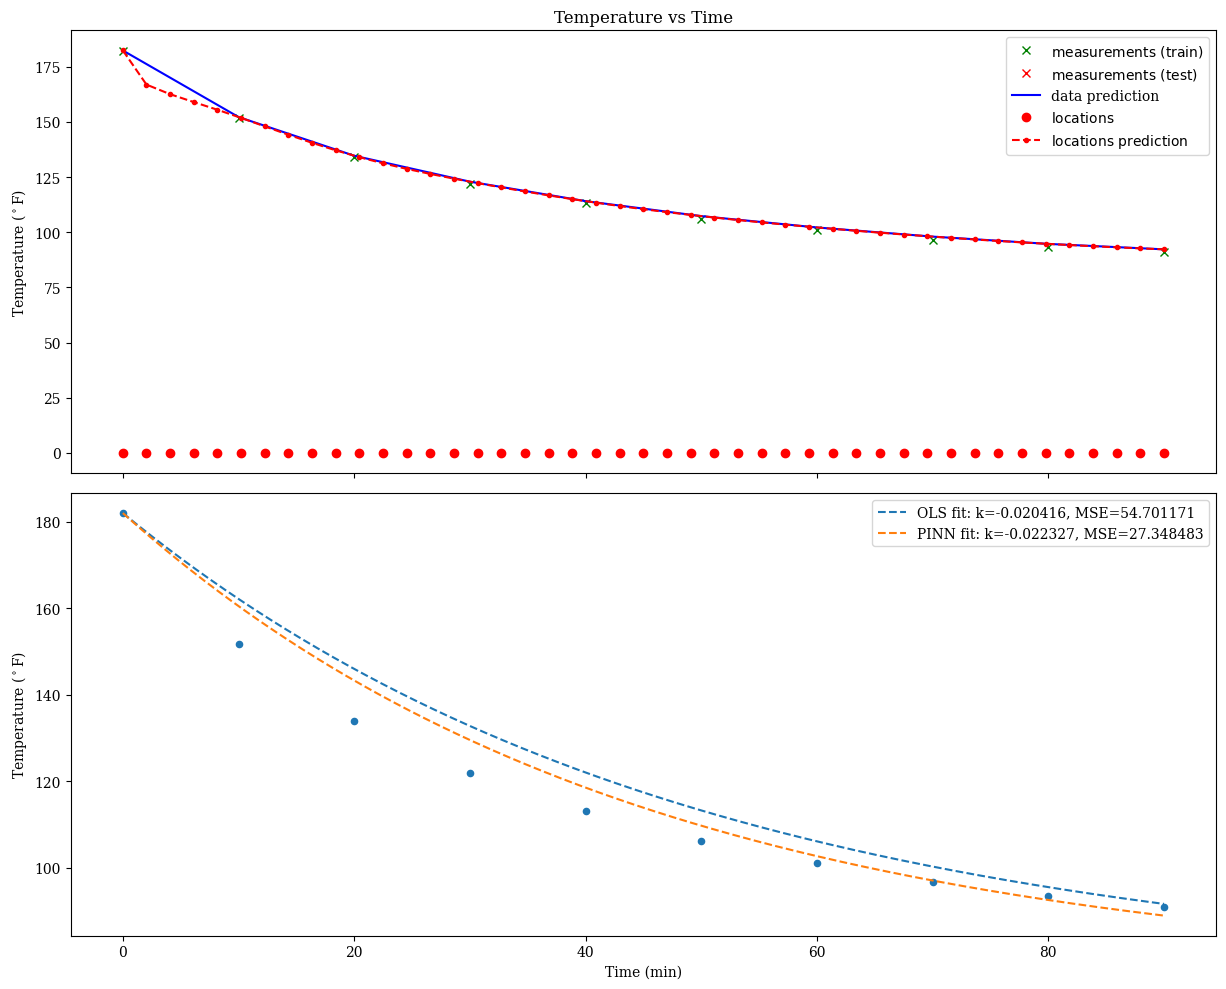

In [118]:
fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10), sharex=True)

model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

X.query(f"time <= {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query(f"time > {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"data prediction"
) 

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
) 

# ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Temperature ($^\circ$F)")
ax1.set_title("Temperature vs Time")
ax1.legend()


X.plot.scatter(x='time', y='temperature', ax=ax2)
t = np.linspace(0, 90, 1000)

T = (X['temperature'][0] - S) * np.exp(k * t) + S
_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(k * X['time']) + S)
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"OLS fit: k={k:.6f}, MSE={_mse:.6f}",
) 

_mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(_k.item() * X['time']) + S)
T = (X['temperature'][0] - S) * np.exp(_k.item() * t) + S
ax2.plot(
    t,
    T, 
    linestyle="--",
    label=f"PINN fit: k={_k.item():.6f}, MSE={_mse:.6f}",
) 

ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature ($^\circ$F)")
ax2.legend()

plt.tight_layout()